# "Классификация договора в зависимости от предмета по второму уровню ОКПД2" ≡ "Извлечение содержания предмета сделки из текстов документов"

### Подготовка. Введение.
1. Поскольку коммерческие данные получить быстро не удалось, было принято решение использовать публичные данные, доступные на [госзакупках](https://zakupki.gov.ru/epz/main/public/home.html).
2. В связи с таким изменением подхода появилась необходимость переформулирования задачи, теперь она сформулирована так: "Классификация договора в зависимости от предмета по второму уровню ОКПД2". Классификатор ОКПД2 можно получить, например, [здесь](https://www.consultant.ru/document/cons_doc_LAW_163703/). Таким образом, цель изменилась до: по разделу предмета договора вернуть второй уровень кода ОКПД2.
Важное замечание: поскольку предметов договора в данном случае может быть много, то мы имеем дело с многоклассовой классификацией.
3. Датасет состоит из 199913 записей в формате JSON, содержащие три поля "regNum" - реестровый номер контракта, "contractSubjectFull" - полный текст предмета договора, "OKPD2_codes" - набор ОКПД2 кодов из договора. Датасет расположени по [адресу](https://www.kaggle.com/datasets/aldarovalexander/contract). Сам датасет был получен путем парсинга части исполненных договоров за 2022 год, которые бы имели формат верный DOCX и разбора формализованной части договоров. Часть процесса получения, например, из графического представления договора верного текста предмета в данном исследовании опущена, поскольку для целей самого исследования не представляет интереса.
4. Блокнот доступен в [колабе](https://colab.research.google.com/github/aldarovav/YearProject/blob/main/analysis.ipynb)


### Импорт библиотек и настройка

In [1]:
!pip install pymorphy3
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import os
import io
import requests
import json
import kagglehub
import pymorphy3
import nltk
import matplotlib.pyplot as plt
import tqdm

from io import StringIO
from collections import Counter

# Настройка отображения
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Библиотеки загружены")
print("Текущая рабочая директория:", os.getcwd()) #Необходимо для избежания путаницы между средами выполнения

C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Библиотеки загружены
Текущая рабочая директория: c:\Users\Lenovo\YandexDisk\Учеба\ВШЭ ИИ\YearProject\YearProject


### Разведочный анализ данных

In [3]:
from kagglehub import KaggleDatasetAdapter
import pandas as pd

# Указываем конкретный файл для загрузки
file_path = "contracts_dataset_unique.json"

# Сначала получим путь к файлу
dataset_path = kagglehub.dataset_download("aldarovalexander/contract")
full_file_path = f"{dataset_path}/{file_path}"

# Загрузим JSON с указанием dtype - это необходимо, поскольку иначе read_json воспринимает regNum как число и обрезает его, что создает неуникальные записи
df = pd.read_json(full_file_path, dtype={'regNum': str})


In [4]:

# Посмотрим первые записи
print("Первые 5 записей:", df.head(3))

Первые 5 записей:                 regNum  \
0  0166300031414000004   
1  0324300007314000014   
2  0366300032914000027   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [5]:
df.describe(include='all')

,regNum,contractSubjectFull,OKPD2_codes
count,199913,199913,199913
unique,199913,154919,1046
top,3891102874222000031,"1.1. Поставщик обязуется передать в собственность продукты питания (далее - Товар) Заказчику в обусловленный настоящим Контрактом срок, согласно Спецификации (Приложение N 1 к настоящему Контракту), Техническому заданию (Приложение N 2 к настоящему Контракту), а Заказчик обязуется принять и оплатить Товар в порядке и на условиях, предусмотренных настоящим Контрактом. 1.2. Наименование поставляемого Товара указаны в Спецификации (Приложение N 1 к настоящему Контракту). Функциональные, технические и качественные характеристики Товара установлены в Техническом задании (Приложение N 2 к настоящему Контракту).",[21]
freq,1,4444,36052


In [6]:
# Первичный анализ
print(f"Размер датасета: {df.shape}")
print(f"Колонки: {list(df.columns)}")
print("\nТипы данных:")
print(df.dtypes)


Размер датасета: (199913, 3)
Колонки: ['regNum', 'contractSubjectFull', 'OKPD2_codes']

Типы данных:
regNum                 object
contractSubjectFull    object
OKPD2_codes            object
dtype: object


In [7]:
# Более детальный анализ
print(f"Общее количество записей: {len(df)}")
print(f"Количество уникальных номеров контрактов: {df['regNum'].nunique()}")
print(f"Неуникальные номера контрактов: {df[df.duplicated('regNum', keep=False)]}")


Общее количество записей: 199913
Количество уникальных номеров контрактов: 199913
Неуникальные номера контрактов: Empty DataFrame
Columns: [regNum, contractSubjectFull, OKPD2_codes]
Index: []


Очень хороший результат - все записи уникальны

In [8]:
# Анализ ОКПД кодов (списков)
all_okpd2_codes = df['OKPD2_codes'].explode() # Развернем списки ОКПД2 кодов для анализа
print(f"Всего ОКПД2 кодов (с повторениями): {len(all_okpd2_codes)}")
print(f"Уникальных ОКПД2 кодов: {all_okpd2_codes.nunique()}")
top_10_okpd2 = all_okpd2_codes.value_counts().head(10)
print(f"Топ-10 самых частых ОКПД2 кодов: {top_10_okpd2}")


Всего ОКПД2 кодов (с повторениями): 211887
Уникальных ОКПД2 кодов: 84
Топ-10 самых частых ОКПД2 кодов: OKPD2_codes
21    36805
10    28412
32    21144
26    10968
20     7493
01     7327
43     6795
17     6455
22     6036
68     4521
Name: count, dtype: int64


In [9]:

# Анализ структуры попадания кодов ОКПД2 в договоры
okpd2_counts = df['OKPD2_codes'].str.len()
print(f"Количество контрактов с одним OKPD2 кодом: {(okpd2_counts == 1).sum()}")
print(f"Количество контрактов с несколькими OKPD2 кодами: {(okpd2_counts > 1).sum()}")
print(f"Максимальное количество OKPD2 кодов в одном контракте: {okpd2_counts.max()}")


Количество контрактов с одним OKPD2 кодом: 191144
Количество контрактов с несколькими OKPD2 кодами: 8769
Максимальное количество OKPD2 кодов в одном контракте: 11


#### Анализ классов

In [10]:
# Анализ классов
combinations = df['OKPD2_codes'].apply(tuple).value_counts()

print("Топ-10 наборов ОКПД2:")
print(combinations.head(10))

print(f"\nВсего уникальных комбинаций: {len(combinations)}")
print(f"Записей с одним кодом: {(df['OKPD2_codes'].apply(len) == 1).sum()}")
print(f"Записей с несколькими кодами: {(df['OKPD2_codes'].apply(len) > 1).sum()}")

Топ-10 наборов ОКПД2:
OKPD2_codes
(21,)    36052
(10,)    26235
(32,)    19288
(26,)    10257
(43,)     6596
(20,)     5322
(01,)     5198
(17,)     4934
(68,)     4512
(80,)     4204
Name: count, dtype: int64

Всего уникальных комбинаций: 1046
Записей с одним кодом: 191144
Записей с несколькими кодами: 8769


📊 РАСПРЕДЕЛЕНИЕ НАБОРОВ ОКПД2
Уникальных наборов: 1046
Всего договоров: 199913

Топ-10 наборов:
1. ('21',): 36052 договоров
2. ('10',): 26235 договоров
3. ('32',): 19288 договоров
4. ('26',): 10257 договоров
5. ('43',): 6596 договоров
6. ('20',): 5322 договоров
7. ('01',): 5198 договоров
8. ('17',): 4934 договоров
9. ('68',): 4512 договоров
10. ('80',): 4204 договоров


([], [])

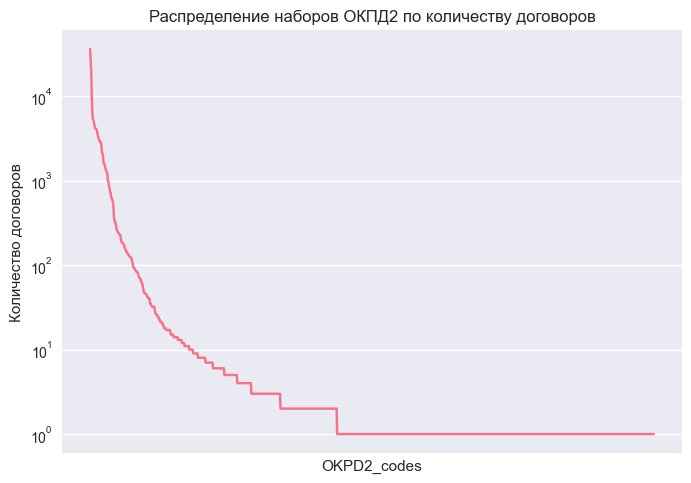

In [11]:
# Считаем частоту каждого уникального набора ОКПД2
combinations = df['OKPD2_codes'].apply(tuple).value_counts()

print("📊 РАСПРЕДЕЛЕНИЕ НАБОРОВ ОКПД2")
print(f"Уникальных наборов: {len(combinations)}")
print(f"Всего договоров: {len(df)}")

# Топ-10 наборов
print("\nТоп-10 наборов:")
for i, (combo, count) in enumerate(combinations.head(10).items(), 1):
    print(f"{i}. {combo}: {count} договоров")

# График

combinations.plot(kind='line')
plt.title('Распределение наборов ОКПД2 по количеству договоров')
plt.ylabel('Количество договоров')
plt.yscale('log')  # Логарифмическая шкала по Y
plt.xticks([])  # Убираем подписи по оси X


Видим, что распределение классов даже на логарифмической шкале требует логарифмизации, что  указывает на неоднородность классов, построим кумулятивное распределение по классам, чтобы увидеть какая часть классов заметает какой объём договоров

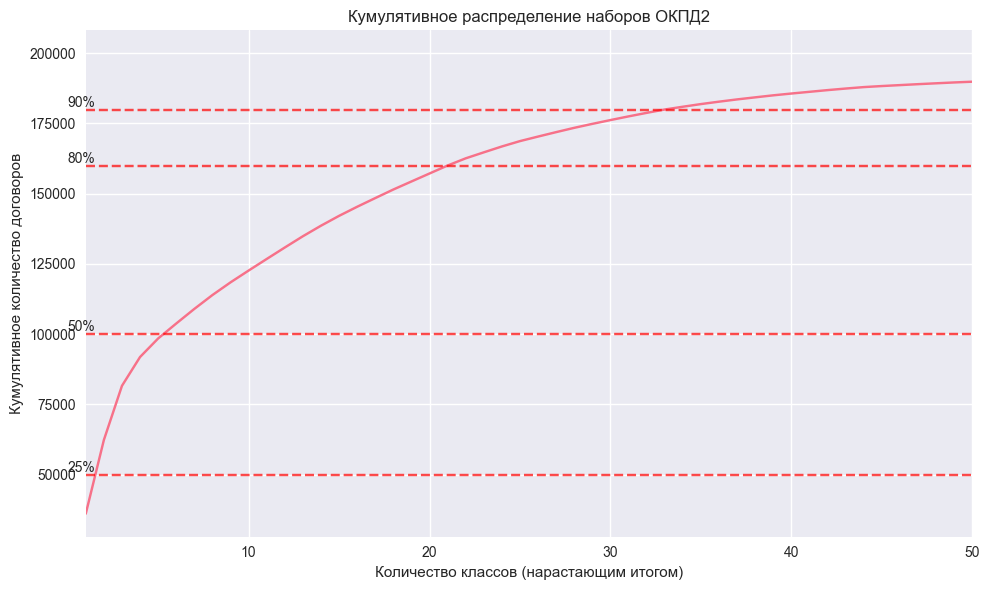

In [12]:
# Кумулятивное распределение
cumulative = combinations.cumsum()
total = len(df)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative) + 1), cumulative.values)

# Ограничиваем ось абсцисс от 1 до 50
plt.xlim(1, 50)

# Добавляем линии процентов
percent_lines = [0.25, 0.5, 0.8, 0.9]
for p in percent_lines:
    value = total * p
    plt.axhline(y=value, color='red', linestyle='--', alpha=0.7)
    plt.text(0, value, f'{p*100:.0f}%', va='bottom', ha='left')

plt.title('Кумулятивное распределение наборов ОКПД2')
plt.ylabel('Кумулятивное количество договоров')
plt.xlabel('Количество классов (нарастающим итогом)')
plt.grid(True)
plt.tight_layout()
plt.show()

Вот теперь очень хорошо видно, чтобы получить 75% попадание, достаточно верно определить один из 20 крупнейших классов

#### Анализ текстов

In [13]:
# Анализ текстовых данных
print(f"Средняя длина contractSubjectFull: {df['contractSubjectFull'].str.len().mean():.0f} символов")
print(f"Максимальная длина contractSubjectFull: {df['contractSubjectFull'].str.len().max()} символов")
print(f"Минимальная длина contractSubjectFull: {df['contractSubjectFull'].str.len().min()} символов")

min_length = df['contractSubjectFull'].str.len().min()
min_length_samples = df[df['contractSubjectFull'].str.len() == min_length].head(10)

print(f"\n10 примеров с минимальной длиной ({min_length} символов):")
for i, row in min_length_samples.iterrows():
    print(f"{i+1}. regNum: {row['regNum']}")
    print(f"   contractSubjectFull: '{row['contractSubjectFull']}'")
    print()

Средняя длина contractSubjectFull: 872 символов
Максимальная длина contractSubjectFull: 9398 символов
Минимальная длина contractSubjectFull: 1 символов

10 примеров с минимальной длиной (1 символов):
6408. regNum: 1526001988422000024
   contractSubjectFull: '.'

6409. regNum: 1526001988422000026
   contractSubjectFull: '.'

6410. regNum: 1526001988422000061
   contractSubjectFull: '.'

6411. regNum: 1526001988422000087
   contractSubjectFull: '.'

6412. regNum: 1526001988422000091
   contractSubjectFull: '.'

6413. regNum: 1526001988422000113
   contractSubjectFull: '.'

24720. regNum: 2121501971922000035
   contractSubjectFull: '\'

42737. regNum: 2234000693422000300
   contractSubjectFull: ','

63980. regNum: 2390603079322000990
   contractSubjectFull: ','

64184. regNum: 2390603735822000174
   contractSubjectFull: ','



Очевидно, что есть некоторые проблемы с заполнением предмета договора. Есть основание считать, что менее 100 символов являются ошибками реализации выборки, проверим эту гипотезу

In [14]:
# Выбор всех записей с длиной contractSubjectFull менее 100 символов
short_texts = df[df['contractSubjectFull'].str.len() < 100]

print(f"Найдено записей с длиной текста менее 100 символов: {len(short_texts)}")
print(f"Это составляет {len(short_texts) / len(df) * 100:.1f}% от общего количества записей")

# Вывод всех найденных записей
print("\nВсе записи с длиной contractSubjectFull < 100 символов:")
for i, (index, row) in enumerate(short_texts.iterrows(), 1):
    print(f"{i}. Длина: {len(row['contractSubjectFull'])} символов")
    print(f"   Текст: '{row['contractSubjectFull']}'")
    
    # Если есть другие столбцы, выводим их тоже
    other_columns = [col for col in df.columns if col != 'contractSubjectFull']
    for col in other_columns:
        print(f"   {col}: {row[col]}")
    print("-" * 50)

Найдено записей с длиной текста менее 100 символов: 2253
Это составляет 1.1% от общего количества записей

Все записи с длиной contractSubjectFull < 100 символов:
1. Длина: 37 символов
   Текст: '1.1. «Заказчик» получает и оплачивает'
   regNum: 1010506281522000044
   OKPD2_codes: ['62']
--------------------------------------------------
2. Длина: 92 символов
   Текст: 'Государственный контракт на оказание услуги по разработке проектно-сметной документации на \'
   regNum: 1301501552722000152
   OKPD2_codes: ['71']
--------------------------------------------------
3. Длина: 73 символов
   Текст: '1.1. Поставщик обязуется поставить лампы светодиодные для нужд ФГБОУ ВО \'
   regNum: 1323401645022000077
   OKPD2_codes: ['27']
--------------------------------------------------
4. Длина: 97 символов
   Текст: '1.1. Поставщик обязуется передать в собственность продукты питания (овощи свежие) для нужд ФКУЗ \'
   regNum: 1231902322121000271
   OKPD2_codes: ['01']
-----------------------------

Действительно обрезанные записи, считаем их ошибочными и удалим из датасета

In [15]:
# Находим индексы записей для удаления
indices_to_drop = df[df['contractSubjectFull'].str.len() < 100].index

# Удаляем записи
df = df.drop(indices_to_drop)

print(f"Удалено {len(indices_to_drop)} записей")
print(f"Осталось {len(df)} записей")

Удалено 2253 записей
Осталось 197660 записей


#### Анализ кодов ОКПД2

In [16]:
# Проверим что идентификатор договора везде заполнен верно
print("Длина regNum:")
print(f"  Минимальная: {df['regNum'].str.len().min()}")
print(f"  Максимальная: {df['regNum'].str.len().max()}")
print(f"  Уникальные длины: {sorted(df['regNum'].str.len().unique())}")


Длина regNum:
  Минимальная: 19
  Максимальная: 19
  Уникальные длины: [np.int64(19)]


In [17]:
# Анализ распределения количества кодов на контракт

count_distribution = okpd2_counts.value_counts().sort_index()
for count, freq in count_distribution.items():
    print(f"  {count} ОКПД2: {freq} контрактов ({freq/len(df)*100:.1f}%)")

  1 ОКПД2: 191144 контрактов (96.7%)
  2 ОКПД2: 6674 контрактов (3.4%)
  3 ОКПД2: 1354 контрактов (0.7%)
  4 ОКПД2: 514 контрактов (0.3%)
  5 ОКПД2: 142 контрактов (0.1%)
  6 ОКПД2: 52 контрактов (0.0%)
  7 ОКПД2: 22 контрактов (0.0%)
  8 ОКПД2: 4 контрактов (0.0%)
  9 ОКПД2: 4 контрактов (0.0%)
  11 ОКПД2: 3 контрактов (0.0%)


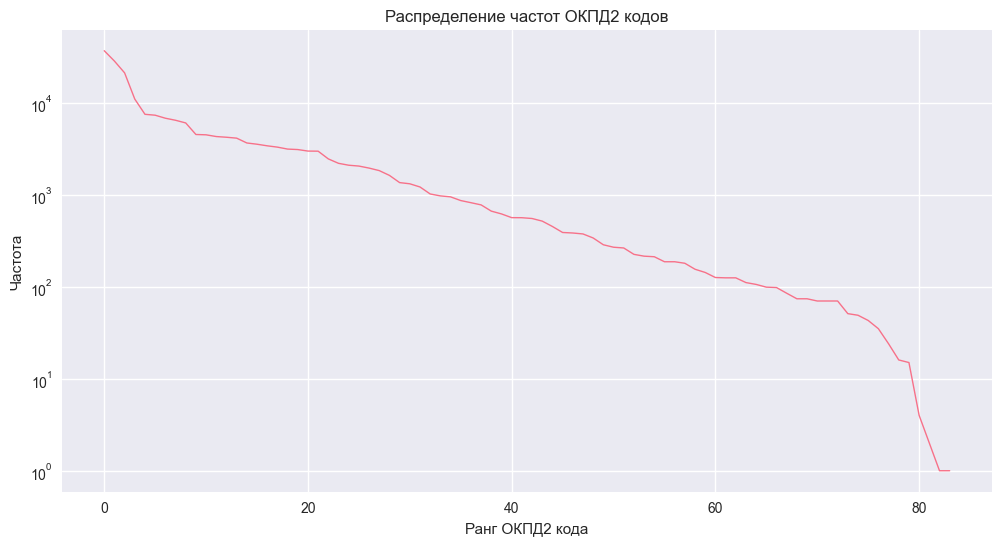

In [18]:
# Строим график распределения частот
all_okpd2_freq = all_okpd2_codes.value_counts()  # Это сет с частотами для каждого уникального кода
plt.figure(figsize=(12, 6))
plt.plot(range(len(all_okpd2_freq)), all_okpd2_freq.values, linewidth=1)
plt.title('Распределение частот ОКПД2 кодов')
plt.xlabel('Ранг ОКПД2 кода')
plt.ylabel('Частота')
plt.grid(True)
plt.yscale('log')  # Логарифмическая шкала для лучшей визуализации
plt.show()


In [19]:

# Дополнительный анализ распределения
print(f"Медианная частота: {all_okpd2_freq.median()}")
print(f"Средняя частота: {all_okpd2_freq.mean():.2f}")
print(f"Максимальная частота: {all_okpd2_freq.max()}")
print(f"Минимальная частота: {all_okpd2_freq.min()}")
print(f"Стандартное отклонение: {all_okpd2_freq.std():.2f}")


Медианная частота: 557.5
Средняя частота: 2522.46
Максимальная частота: 36805
Минимальная частота: 1
Стандартное отклонение: 5651.42


In [20]:
# Анализ долей
total_mentions = all_okpd2_freq.sum()
top_10_percent_share = all_okpd2_freq.head(int(len(all_okpd2_freq) * 0.1)).sum() / total_mentions * 100
top_20_percent_share = all_okpd2_freq.head(int(len(all_okpd2_freq) * 0.2)).sum() / total_mentions * 100
top_25_percent_share = all_okpd2_freq.head(int(len(all_okpd2_freq) * 0.25)).sum() / total_mentions * 100

print(f"На 10% самых частых кодов приходится {top_10_percent_share:.1f}% всех упоминаний")
print(f"На 20% самых частых кодов приходится {top_20_percent_share:.1f}% всех упоминаний")
print(f"На 25% самых частых кодов приходится {top_25_percent_share:.1f}% всех упоминаний")

На 10% самых частых кодов приходится 59.2% всех упоминаний
На 20% самых частых кодов приходится 75.6% всех упоминаний
На 25% самых частых кодов приходится 83.2% всех упоминаний


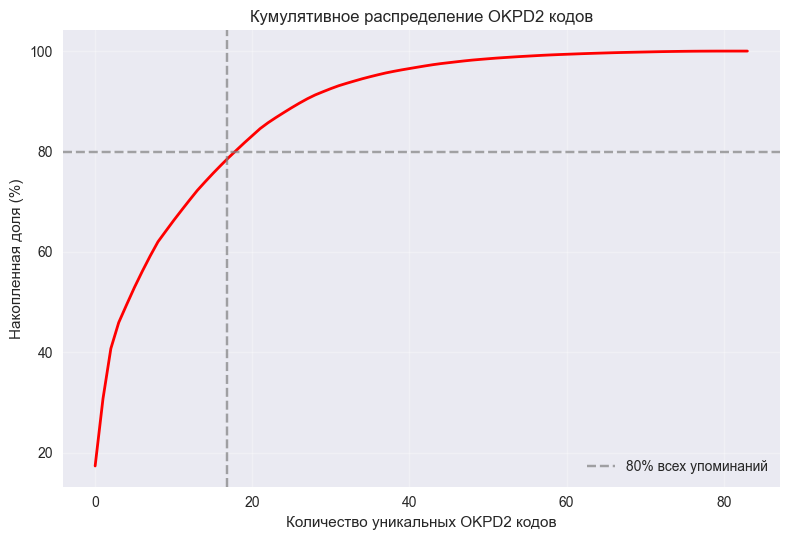

In [21]:
# Кумулятивное распределение
cumulative_share = all_okpd2_freq.cumsum() / total_mentions * 100
plt.plot(range(len(all_okpd2_freq)), cumulative_share, linewidth=2, color='red')
plt.title('Кумулятивное распределение OKPD2 кодов')
plt.xlabel('Количество уникальных OKPD2 кодов')
plt.ylabel('Накопленная доля (%)')
plt.grid(True, alpha=0.3)

# Добавляем ориентиры
plt.axhline(y=80, color='gray', linestyle='--', alpha=0.7, label='80% всех упоминаний')
plt.axvline(x=len(all_okpd2_freq) * 0.2, color='gray', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


В целом картина по распределению кодов и классов по заметаемым долям числа всех договоров почти совпадают, этого следовало ожидать, поскольку самые крупные классы содержат по одному коду ОКПД2

## Облегчение задачи для обработки на CPU

In [22]:
# Сокращаем выборку до a популярных наборов кодов ОКПД2
a = 10 # Самых популярных классов
b = 10000 # Случайным образом выбираем из датасета

df['OKPD2_codes'] = df['OKPD2_codes'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Находим a самых частых наборов OKPD2_codes
top_okpd2 = df['OKPD2_codes'].value_counts().head(a).index

# Фильтруем датасет, оставляя только строки с этими наборами
df = df[df['OKPD2_codes'].isin(top_okpd2)].copy()

print(f"Размер сокращенного датасета: {df.shape}")

# Оставляем только b случайных строк и сбрасываем индексы
n_samples = b
if len(df) > n_samples:
    df = df.sample(n=n_samples, random_state=42).reset_index(drop=True)
    print(f"Датасет сокращен до {n_samples} случайных строк")
else:
    df = df.reset_index(drop=True)
    print(f"Датасет уже содержит только {len(df)} строк")

print(f"Финальный размер датасета: {df.shape}")



Размер сокращенного датасета: (121804, 3)
Датасет сокращен до 10000 случайных строк
Финальный размер датасета: (10000, 3)


## Предобработка текста

In [23]:
# Анализ текстов
print("Длина текстов после очистки пропущенных значений:")
print(df['contractSubjectFull'].str.len().describe())

Длина текстов после очистки пропущенных значений:
count    10000.000000
mean       902.711200
std        616.403007
min        100.000000
25%        612.000000
50%        773.000000
75%       1043.000000
max       7538.000000
Name: contractSubjectFull, dtype: float64


In [24]:
from tqdm import tqdm
#Функция очистки текста от мусора
def clean_text(text):
    if pd.isna(text) or text == '':
        return ""

    prev_text = text
    while True:
        text = text.lower()
        
        # Удаление приложений, ссылок, спецификаций
        text = re.sub(r'\(?(приложение|прил\.?|спецификаци[яией]|далее)\s*№?\s*\d*\)?', ' ', text, flags=re.IGNORECASE)
        
        # Удаление номеров контрактов и идентификаторов
        text = re.sub(r'(контракт|договор)\s*№?\s*\d+[/\-\\]\d+', ' ', text, flags=re.IGNORECASE)
        text = re.sub(r'идентификационный\s+код\s+закупки[:\-\s]*[\d\w]+', ' ', text, flags=re.IGNORECASE)
        
        # Удаление дат
        text = re.sub(r'\d{1,2}\s*[\.\/\\]\s*\d{1,2}\s*[\.\/\\]\s*\d{2,4}', ' ', text)
        text = re.sub(r'"\d{1,2}"\s*\w+\s*\d{4}\s*года?', ' ', text)
        
        # Удаление символа № и номеров
        text = re.sub(r'№\s*\d*', ' ', text)
        text = re.sub(r'\s№\s|^№\s|\s№$', ' ', text)
        
        # Удаление нумерации пунктов (1.1., 1.2. и т.д.)
        text = re.sub(r'\b\d+\.\d+\.', ' ', text)
        text = re.sub(r'^\d+\.', ' ', text)  # В начале строки
        
        # Удаление одиночных цифр
        text = re.sub(r'\s\d{1,2}\s', ' ', text)
        
        # Удаление лишних символов (сохраняем только буквы, цифры и пробелы)
        text = re.sub(r'[^a-zа-я0-9\s]', ' ', text)
        
        # Удаление множественных пробелов
        text = re.sub(r'\s+', ' ', text)
        
        text = text.strip()
        
        # Если текст перестал меняться - выходим
        if text == prev_text:
            break
        prev_text = text
    
    return text

tqdm.pandas(desc="Очистка текста")
df['text_clean'] = df['contractSubjectFull'].progress_apply(clean_text)

Очистка текста:   0%|          | 0/10000 [00:00<?, ?it/s]

Очистка текста: 100%|██████████| 10000/10000 [00:11<00:00, 905.72it/s]


In [25]:
a = 550
print("Пример очистки текста:")
print(df['regNum'].iloc[a])
print("ДО:", df['contractSubjectFull'].iloc[a][:200])
print("ПОСЛЕ:", df['text_clean'].iloc[a][:200])

Пример очистки текста:
2420204679922000060
ДО: 1.1. Поставщик обязуется передать в собственность продукты питания (далее - Товар) Заказчику в обусловленный настоящим Контрактом срок, согласно Спецификации (Приложение № 1 к настоящему Контракту) и 
ПОСЛЕ: поставщик обязуется передать в собственность продукты питания товар заказчику в обусловленный настоящим контрактом срок согласно к настоящему контракту и техническому заданию к настоящему контракту а 


In [26]:
# Удаление стоп-слов
from nltk.corpus import stopwords

# Скачивание стоп-слов
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

# Доменные стоп-слова
domain_stopwords = [
    'контракт', 'договор', 'приложение', 'пункт', 'статья', 'далее', 
    'согласно', 'также', 'например', 'иной', 'другой', 'обязан', 
    'обязана', 'обязаны', 'обязано', 'условие', 'следующий', 'документ', 
    'соглашение', 'протокол', 'решение', 'акт', 'отчет', 'настоящий',
    'настоящего', 'настоящем', 'настоящему']

# Добавляем предлоги и союзы
prepositions = ['по', 'в', 'и', 'с', 'у', 'на', 'за', 'к', 'о', 'от', 'до', 'из', 'без']
conjunctions = ['а', 'но', 'или', 'то', 'как', 'что', 'чтобы', 'if', 'and', 'or']

custom_stopwords = set(russian_stopwords + domain_stopwords + prepositions + conjunctions)
print(custom_stopwords)

#Функция удаления стоп-слов
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in custom_stopwords]


{'ему', 'всего', 'всегда', 'наконец', 'еще', 'иной', 'потому', 'следующий', 'в', 'по', 'есть', 'нее', 'может', 'ж', 'много', 'этого', 'if', 'мы', 'тот', 'была', 'были', 'того', 'для', 'раз', 'надо', 'этой', 'далее', 'же', 'до', 'чего', 'о', 'мне', 'какой', 'хорошо', 'моя', 'зачем', 'потом', 'там', 'она', 'теперь', 'во', 'у', 'этом', 'статья', 'настоящему', 'лучше', 'от', 'ведь', 'нас', 'над', 'через', 'здесь', 'чуть', 'даже', 'так', 'куда', 'можно', 'к', 'быть', 'вдруг', 'пункт', 'опять', 'один', 'договор', 'перед', 'все', 'ли', 'ее', 'тебя', 'ей', 'кто', 'такой', 'если', 'документ', 'протокол', 'другой', 'что', 'ты', 'обязана', 'уже', 'себя', 'обязано', 'хоть', 'них', 'чтобы', 'между', 'я', 'бы', 'без', 'конечно', 'тоже', 'приложение', 'нет', 'мой', 'было', 'они', 'сам', 'три', 'вы', 'а', 'иногда', 'ним', 'совсем', 'только', 'из', 'ничего', 'ней', 'за', 'их', 'об', 'более', 'как', 'всех', 'ни', 'был', 'под', 'будет', 'или', 'свою', 'меня', 'также', 'него', 'and', 'при', 'себе', 'никог

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Создаем анализатор pymorphy3
morph = pymorphy3.MorphAnalyzer()

#Функция лемматизации текста
def lemmatize_tokens(tokens):
    lemmatized_tokens = []
    for token in tokens:
        try:
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            lemmatized_tokens.append(lemma)
        except Exception:
            lemmatized_tokens.append(token)
    return lemmatized_tokens

In [28]:
#Функция токенизации текста 
def tokenize_text(text):
    return text.split()

In [29]:
# Функция основной обработки текста
def advanced_text_processing(text):
    # Проверка на непустоту
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Очистка текста от мусора
    cleaned_text = clean_text(text)
    
    # Токенизация текста
    tokens = tokenize_text(cleaned_text)
    
    # Удаление стоп-слов (первый проход)
    tokens = remove_stopwords(tokens)
    
    # Лемматизация токенов
    lemmatized_tokens = lemmatize_tokens(tokens)
    
    # Удаление стоп-слов после лемматизации (второй проход)
    final_tokens = remove_stopwords(lemmatized_tokens)
    
    return ' '.join(final_tokens)

In [30]:
from tqdm import tqdm

# Применяем ко всему датафрейму
print("Начата обработка всего датасета...")

def sequential_text_processing(series):

    texts = series.tolist()
    total_texts = len(texts)
   
    results = []
    
    # Обрабатываем каждый текст с прогресс-баром
    for text in tqdm(texts, total=total_texts, desc="Обработка текстов", unit="текст"):
        result = advanced_text_processing(text)
        results.append(result)
    
    return results

# Использование:
print("=== Последовательная обработка ===")
df['text_processed'] = sequential_text_processing(df['contractSubjectFull'])

print("Обработка завершена!")

Начата обработка всего датасета...
=== Последовательная обработка ===


Обработка текстов: 100%|██████████| 10000/10000 [02:09<00:00, 76.95текст/s]

Обработка завершена!


In [31]:
a = 550
print("Пример очистки текста:")
print(df['regNum'].iloc[a])
print("ДО:", df['contractSubjectFull'].iloc[a][:200])
print("ПОСЛЕ:", df['text_clean'].iloc[a][:200])
print("ПОСЛЕ:", df['text_processed'].iloc[a][:200])

Пример очистки текста:
2420204679922000060
ДО: 1.1. Поставщик обязуется передать в собственность продукты питания (далее - Товар) Заказчику в обусловленный настоящим Контрактом срок, согласно Спецификации (Приложение № 1 к настоящему Контракту) и 
ПОСЛЕ: поставщик обязуется передать в собственность продукты питания товар заказчику в обусловленный настоящим контрактом срок согласно к настоящему контракту и техническому заданию к настоящему контракту а 
ПОСЛЕ: поставщик обязываться передать собственность продукт питание товар заказчик обусловить срок технический задание заказчик обязываться принять оплатить товар порядок предусмотреть наименование количеств


In [32]:
# Статистика обработки
print(f"Общее количество записей: {len(df)}")
print(f"Средняя длина исходного текста: {df['contractSubjectFull'].str.len().mean():.0f} символов")
print(f"Средняя длина обработанного текста: {df['text_processed'].str.len().mean():.0f} символов")
print(f"Сжатие текста: {(1 - df['text_processed'].str.len().mean() / df['contractSubjectFull'].str.len().mean()) * 100:.1f}%")

Общее количество записей: 10000
Средняя длина исходного текста: 903 символов
Средняя длина обработанного текста: 603 символов
Сжатие текста: 33.2%


In [33]:
# Показываем примеры обработки
for i in range(min(5, len(df))):
    print(f"\nПример {i+1}:")
    original = df['contractSubjectFull'].iloc[i]
    processed = df['text_processed'].iloc[i]
    
    print("ДО:", original[:150] + "..." if len(original) > 150 else original)
    print("ПОСЛЕ:", processed[:150] + "..." if len(processed) > 150 else processed)
    print("-" * 80)


Пример 1:
ДО: 1.1. В соответствии с Контрактом Поставщик обязуется в порядке и сроки, предусмотренные Контрактом, осуществить поставку лекарственных препаратов для ...
ПОСЛЕ: соответствие поставщик обязываться порядок срок предусмотренный осуществить поставка лекарственный препарат медицинский применение код окпд 134 товар ...
--------------------------------------------------------------------------------

Пример 2:
ДО: 1.1. Предметом настоящего Контракта является приобретение в муниципальную собственность муниципального образования город Балаково жилого помещения пос...
ПОСЛЕ: предмет являться приобретение муниципальный собственность муниципальный образование город балаково жилой помещение посредством участие долевой строите...
--------------------------------------------------------------------------------

Пример 3:
ДО: 1.1. В соответствии с Контрактом Поставщик обязуется в порядке и сроки, предусмотренные Контрактом, осуществить поставку медицинских изделий (набор дл...
ПОСЛЕ: со

In [34]:
# Анализ эффективности обработки
empty_processed = df['text_processed'].str.strip().eq('').sum()
print(f"Пустых текстов после обработки: {empty_processed}")
print(f"Уникальных обработанных текстов: {df['text_processed'].nunique()}")

# Топ-10 самых частых слов после обработки
from collections import Counter
all_words = ' '.join(df['text_processed'].dropna()).split()
word_freq = Counter(all_words)
print(f"\nТоп-10 самых частых слов после обработки:")
for word, freq in word_freq.most_common(10):
    print(f"  {word}: {freq}")

Пустых текстов после обработки: 0
Уникальных обработанных текстов: 8009

Топ-10 самых частых слов после обработки:
  товар: 42271
  заказчик: 19378
  обязываться: 18298
  технический: 17124
  поставщик: 16001
  срок: 14241
  порядок: 13767
  соответствие: 12124
  поставка: 11882
  принять: 8962


Топ-10 самых частых слов после обработки:
  обязуется: 340701
  №: 281243
  (далее: 235462
  соответствии: 215894
  (Приложение: 205405
  1: 202434
  -: 198649
  Товара: 190669
  Поставщик: 183092
  (приложение: 178492

Такое распределение указывает на то, что можно подрезать скобки, знаки номеров, слова: обязуется, далее, приложение

### Разметка данных

In [35]:
print(f"Всего записей: {len(df)}")
print(f"Записей с OKPD2: {df['OKPD2_codes'].notna().sum()}")
print(f"Процент размеченных данных: {df['OKPD2_codes'].notna().mean():.2%}")

# Анализ структуры OKPD2 кодов
df['okpd_count'] = df['OKPD2_codes'].apply(lambda x: len(x) if x else 0)
print("\nРаспределение количества кодов OKPD2 на запись:")
print(df['okpd_count'].value_counts().sort_index())

Всего записей: 10000
Записей с OKPD2: 10000
Процент размеченных данных: 100.00%

Распределение количества кодов OKPD2 на запись:
okpd_count
1    10000
Name: count, dtype: int64


In [36]:
# Извлечение и нормализация целевых меток
def extract_okpd_labels(okpd_codes):
    """Извлекает все коды ОКПД2 для классификации"""
    if not okpd_codes or len(okpd_codes) == 0:
        return []
    
    # Извлекаем все коды и нормализуем их до 2-значного уровня
    normalized_codes = []
    for code in okpd_codes:
        if len(code) >= 2:
            normalized_codes.append(code[:2])  # Первые 2 цифры - раздел
        else:
            normalized_codes.append(code)
    
    return normalized_codes

# Создание бинарной матрицы для мульти-лейбл классификации
from sklearn.preprocessing import MultiLabelBinarizer

# Создаем целевую переменную - список всех кодов ОКПД2
df['target'] = df['OKPD2_codes'].apply(extract_okpd_labels)

print("Распределение количества меток на запись:")
print(df['target'].apply(len).value_counts().sort_index())

print("\nОбщая статистика по меткам:")
print(f"Всего записей: {len(df)}")
print(f"Записей без меток: {df['target'].apply(len).eq(0).sum()}")

# Анализ меток
all_labels = [label for sublist in df['target'] for label in sublist]
print(f"Всего меток (с повторениями): {len(all_labels)}")

print("\nУровень детализации меток:")
label_lengths = pd.Series([len(label) for label in all_labels])
print(label_lengths.value_counts().sort_index())

print("\nТоп-10 самых частых меток ОКПД2:")
from collections import Counter
label_counts = Counter(all_labels)
for label, count in label_counts.most_common(10):
    print(f"{label}: {count} раз")

print(f"\nВсего уникальных меток: {len(label_counts)}")

# Получаем все уникальные метки (теперь столбец 'target' существует)
all_labels = [label for sublist in df['target'] for label in sublist]
unique_labels = sorted(set(all_labels))

print(f"Уникальные метки для классификации: {unique_labels}")

# Создаем бинарную матрицу
mlb = MultiLabelBinarizer(classes=unique_labels)
target_matrix = mlb.fit_transform(df['target'])

# Создаем DataFrame с бинарными метками
target_df = pd.DataFrame(target_matrix, columns=mlb.classes_, index=df.index)

print(f"\nСоздано {len(unique_labels)} уникальных меток ОКПД2")
print(f"Размер матрицы целевых переменных: {target_matrix.shape}")
print(f"Пример бинарных меток для первых 5 записей:")
print(target_df.head())

Распределение количества меток на запись:
target
1    10000
Name: count, dtype: int64

Общая статистика по меткам:
Всего записей: 10000
Записей без меток: 0
Всего меток (с повторениями): 10000

Уровень детализации меток:
2    10000
Name: count, dtype: int64

Топ-10 самых частых меток ОКПД2:
21: 3032 раз
10: 2121 раз
32: 1559 раз
26: 796 раз
43: 530 раз
20: 448 раз
01: 412 раз
17: 387 раз
68: 368 раз
80: 347 раз

Всего уникальных меток: 10
Уникальные метки для классификации: ['01', '10', '17', '20', '21', '26', '32', '43', '68', '80']

Создано 10 уникальных меток ОКПД2
Размер матрицы целевых переменных: (10000, 10)
Пример бинарных меток для первых 5 записей:
   01  10  17  20  21  26  32  43  68  80
0   0   0   0   0   1   0   0   0   0   0
1   0   0   0   0   0   0   0   0   1   0
2   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   1   0   0   0
4   0   0   0   0   0   0   1   0   0   0


In [37]:
# Анализ качества разметки для мульти-лейбл классификации
# Смотрим примеры текстов для самых частых классов

# Получаем самые частые отдельные метки (не списки)
top_labels = label_counts.most_common(5)
sample_labels = [label for label, count in top_labels]

for class_label in sample_labels:
    # Ищем записи, которые содержат данную метку
    mask = df['target'].apply(lambda x: class_label in x)
    class_texts = df[mask]['text_clean'].head(2)
    
    print(f"\n--- Метка {class_label} ({mask.sum()} примеров) ---")
    for i, text in enumerate(class_texts):
        print(f"{i+1}. {text[:150]}...")
    print(f"Все метки для этой категории: {df[mask]['target'].iloc[0] if len(df[mask]) > 0 else 'нет примеров'}")


--- Метка 21 (3032 примеров) ---
1. в соответствии с контрактом поставщик обязуется в порядке и сроки предусмотренные контрактом осуществить поставку лекарственных препаратов для медицин...
2. в соответствии с контрактом поставщик обязуется в порядке и сроки предусмотренные контрактом осуществить поставку лекарственного препарата для медицин...
Все метки для этой категории: ['21']

--- Метка 10 (2121 примеров) ---
1. поставщик обязуется передать в собственность продукты питания рыбы минтай горбуша на квартал 2023 года товар заказчику в обусловленный настоящим контр...
2. поставщик обязуется передать в собственность продукты питания бакалея мука товар заказчику в обусловленный настоящим контрактом срок согласно n к наст...
Все метки для этой категории: ['10']

--- Метка 32 (1559 примеров) ---
1. в соответствии с контрактом поставщик обязуется в порядке и сроки предусмотренные контрактом осуществить поставку медицинских изделий набор для энтера...
2. в соответствии с контрактом поставщи

In [38]:
# Обработка проблем разметки для мульти-лейбл классификации

# 1. Анализ записей без меток (пустые списки)
empty_targets = df['target'].apply(len) == 0
print(f"Записей без меток (пустые списки): {empty_targets.sum()}")

# 2. Анализ малочисленных отдельных меток
# Собираем статистику по всем отдельным меткам
all_labels = [label for sublist in df['target'] for label in sublist]
label_counts = Counter(all_labels)

# Находим малочисленные метки (менее 5 примеров)
small_labels = {label: count for label, count in label_counts.items() if count < 5}
print(f"Малочисленные отдельные метки (менее 5 примеров): {len(small_labels)}")

# 3. Анализ записей с редкими метками
records_with_small_labels = df['target'].apply(
    lambda labels: any(label in small_labels for label in labels)
).sum()
print(f"Записей, содержащих хотя бы одну малочисленную метку: {records_with_small_labels}")

# 4. Решение: несколько стратегий
print("\n=== СТРАТЕГИИ ОБРАБОТКИ ===")

# Стратегия 1: Удаление записей без меток
df_clean = df[~empty_targets].copy()
print(f"После удаления пустых меток: {len(df_clean)} записей")

# Стратегия 2: Удаление малочисленных меток из списков
def remove_small_labels(labels, small_labels_set):
    """Удаляет малочисленные метки из списка"""
    return [label for label in labels if label not in small_labels_set]

small_labels_set = set(small_labels.keys())
df_clean['target_clean'] = df_clean['target'].apply(
    lambda x: remove_small_labels(x, small_labels_set)
)

# Проверяем, не остались ли записи без меток после очистки
empty_after_clean = df_clean['target_clean'].apply(len) == 0
print(f"Записей без меток после очистки: {empty_after_clean.sum()}")

# Удаляем записи, которые остались без меток после очистки
df_final = df_clean[~empty_after_clean].copy()

print(f"Итоговый размер датасета: {len(df_final)} записей")

# Анализ результатов очистки
all_labels_final = [label for sublist in df_final['target_clean'] for label in sublist]
label_counts_final = Counter(all_labels_final)

print(f"Уникальных меток после очистки: {len(label_counts_final)}")
print(f"Минимальное количество примеров на метку: {min(label_counts_final.values())}")
print(f"Максимальное количество примеров на метку: {max(label_counts_final.values())}")

# Статистика по количеству меток на запись после очистки
labels_per_record_final = df_final['target_clean'].apply(len)
print(f"\nРаспределение количества меток на запись после очистки:")
print(labels_per_record_final.value_counts().sort_index())

Записей без меток (пустые списки): 0
Малочисленные отдельные метки (менее 5 примеров): 0
Записей, содержащих хотя бы одну малочисленную метку: 0

=== СТРАТЕГИИ ОБРАБОТКИ ===
После удаления пустых меток: 10000 записей
Записей без меток после очистки: 0
Итоговый размер датасета: 10000 записей
Уникальных меток после очистки: 10
Минимальное количество примеров на метку: 347
Максимальное количество примеров на метку: 3032

Распределение количества меток на запись после очистки:
target_clean
1    10000
Name: count, dtype: int64


### Анализ размеченных данных

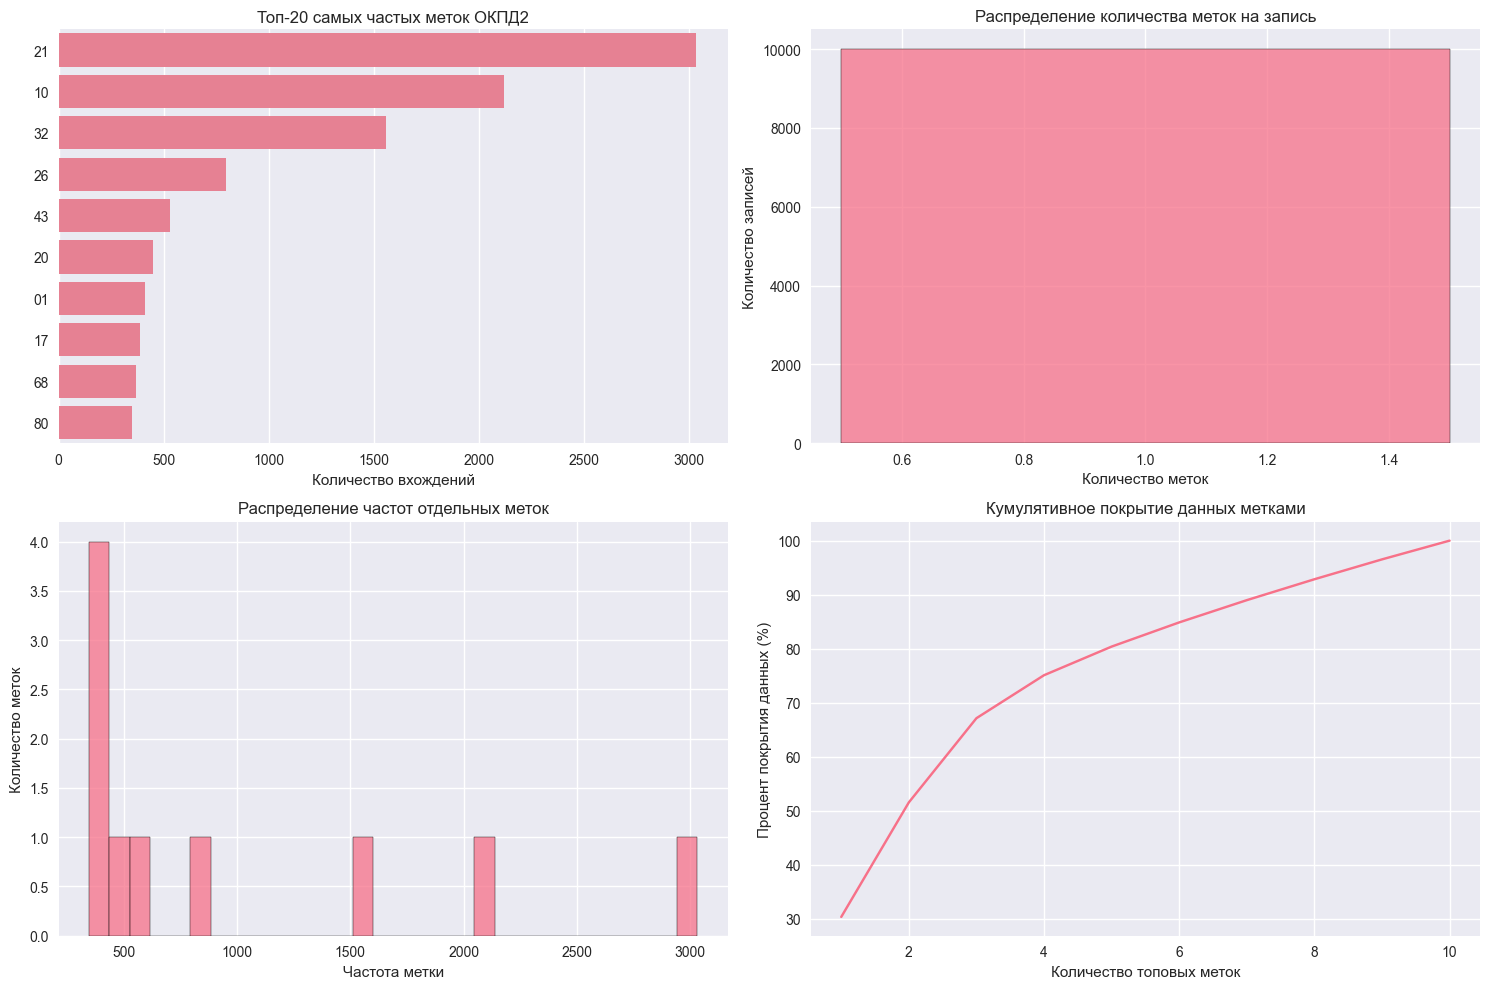

=== СТАТИСТИКА МУЛЬТИ-ЛЕЙБЛ ДАННЫХ ===
Всего записей: 10000
Всего уникальных меток: 10
Общее количество вхождений меток: 10000

Распределение количества меток на запись:
  1 меток: 10000 записей (100.0%)

Статистика по отдельным меткам:
Медианная частота метки: 489.0
Минимальная частота: 347
Максимальная частота: 3032
Средняя частота: 1000.0

Анализ покрытия меток:
Топ-5 меток покрывают 80.4% данных
Топ-10 меток покрывают 100.0% данных


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Статистика для мульти-лейбл классификации
plt.figure(figsize=(15, 10))

# 1. Топ-20 самых частых отдельных меток
plt.subplot(2, 2, 1)
top_labels = label_counts_final.most_common(20)
labels, counts = zip(*top_labels)
sns.barplot(x=list(counts), y=list(labels))
plt.title('Топ-20 самых частых меток ОКПД2')
plt.xlabel('Количество вхождений')

# 2. Распределение количества меток на запись
plt.subplot(2, 2, 2)
labels_per_record = df['target'].apply(len)
sns.histplot(labels_per_record, bins=30, discrete=True)
plt.title('Распределение количества меток на запись')
plt.xlabel('Количество меток')
plt.ylabel('Количество записей')

# 3. Распределение размеров классов (отдельных меток)
plt.subplot(2, 2, 3)
class_sizes = list(label_counts_final.values())
sns.histplot(class_sizes, bins=30)
plt.title('Распределение частот отдельных меток')
plt.xlabel('Частота метки')
plt.ylabel('Количество меток')

# 4. Кумулятивное покрытие данных
plt.subplot(2, 2, 4)
cumulative_counts = []
current_sum = 0
for count in sorted(class_sizes, reverse=True):
    current_sum += count
    cumulative_counts.append(current_sum)

total_labels = sum(class_sizes)
cumulative_percentage = [x / total_labels * 100 for x in cumulative_counts]

plt.plot(range(1, len(cumulative_percentage) + 1), cumulative_percentage)
plt.title('Кумулятивное покрытие данных метками')
plt.xlabel('Количество топовых меток')
plt.ylabel('Процент покрытия данных (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Статистика по мульти-лейбл данным
print("=== СТАТИСТИКА МУЛЬТИ-ЛЕЙБЛ ДАННЫХ ===")
print(f"Всего записей: {len(df)}")
print(f"Всего уникальных меток: {len(label_counts_final)}")
print(f"Общее количество вхождений меток: {sum(label_counts_final.values())}")

print(f"\nРаспределение количества меток на запись:")
labels_count_stats = labels_per_record.value_counts().sort_index()
for count, freq in labels_count_stats.items():
    percentage = freq / len(df) * 100
    print(f"  {count} меток: {freq} записей ({percentage:.1f}%)")

print(f"\nСтатистика по отдельным меткам:")
print(f"Медианная частота метки: {pd.Series(class_sizes).median()}")
print(f"Минимальная частота: {min(class_sizes)}")
print(f"Максимальная частота: {max(class_sizes)}")
print(f"Средняя частота: {pd.Series(class_sizes).mean():.1f}")

# Анализ покрытия
print(f"\nАнализ покрытия меток:")
top_n = [5, 10, 20, 50]
for n in top_n:
    if n <= len(label_counts_final):
        coverage = sum([count for _, count in label_counts_final.most_common(n)]) / sum(label_counts_final.values()) * 100
        print(f"Топ-{n} меток покрывают {coverage:.1f}% данных")

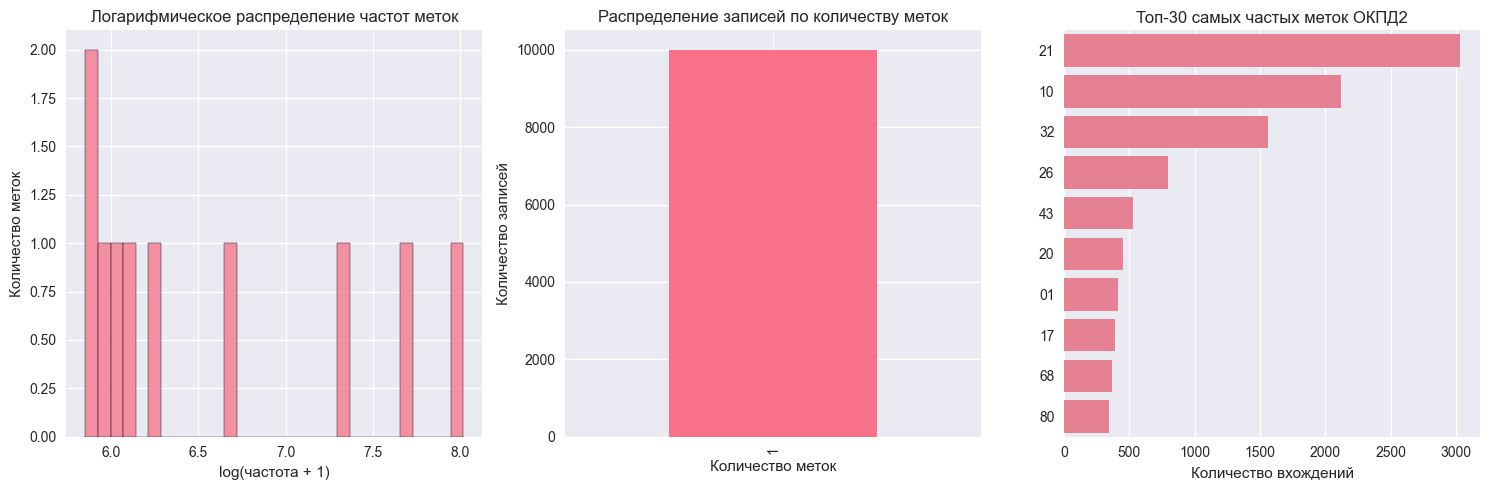


=== АНАЛИЗ КОМБИНАЦИЙ МЕТОК ===
Топ-10 самых частых комбинаций меток:
1. ['21']: 3032 записей (30.3%)
2. ['10']: 2121 записей (21.2%)
3. ['32']: 1559 записей (15.6%)
4. ['26']: 796 записей (8.0%)
5. ['43']: 530 записей (5.3%)
6. ['20']: 448 записей (4.5%)
7. ['01']: 412 записей (4.1%)
8. ['17']: 387 записей (3.9%)
9. ['68']: 368 записей (3.7%)
10. ['80']: 347 записей (3.5%)

Коэффициент сбалансированности (min/max): 0.1144
Стандартное отклонение частот: 931.7


In [40]:
# Дополнительный анализ сбалансированности
plt.figure(figsize=(15, 5))

# 1. Логарифмическое распределение частот меток
plt.subplot(1, 3, 1)
class_sizes_series = pd.Series(class_sizes)
sns.histplot(np.log1p(class_sizes_series), bins=30)
plt.title('Логарифмическое распределение частот меток')
plt.xlabel('log(частота + 1)')
plt.ylabel('Количество меток')

# 2. Количество меток vs количество записей
plt.subplot(1, 3, 2)
labels_per_record.value_counts().sort_index().plot(kind='bar')
plt.title('Распределение записей по количеству меток')
plt.xlabel('Количество меток')
plt.ylabel('Количество записей')

# 3. Топ-30 меток (более детально)
plt.subplot(1, 3, 3)
top_30_labels = label_counts_final.most_common(30)
labels_30, counts_30 = zip(*top_30_labels)
sns.barplot(x=list(counts_30), y=list(labels_30))
plt.title('Топ-30 самых частых меток ОКПД2')
plt.xlabel('Количество вхождений')

plt.tight_layout()
plt.show()

# Анализ самых популярных комбинаций меток
print("\n=== АНАЛИЗ КОМБИНАЦИЙ МЕТОК ===")
from collections import Counter

# Анализируем комбинации меток (первые 2-3 самые частые)
label_combinations = df['target'].apply(tuple).value_counts().head(10)

print("Топ-10 самых частых комбинаций меток:")
for i, (combo, count) in enumerate(label_combinations.items(), 1):
    print(f"{i}. {list(combo)}: {count} записей ({count/len(df)*100:.1f}%)")

# Анализ сбалансированности
print(f"\nКоэффициент сбалансированности (min/max): {min(class_sizes)/max(class_sizes):.4f}")
print(f"Стандартное отклонение частот: {pd.Series(class_sizes).std():.1f}")

In [41]:
# Анализ для подготовки к ML
print("\n=== АНАЛИЗ ДЛЯ ПОДГОТОВКИ К ML ===")

# Рекомендации по обработке несбалансированности
imbalance_ratio = max(class_sizes) / min(class_sizes)
print(f"Коэффициент несбалансированности: {imbalance_ratio:.1f}")

if imbalance_ratio > 100:
    print("⚠️  Высокая несбалансированность - рекомендуется:")
    print("   - Использовать взвешенные функции потерь")
    print("   - Применить oversampling/undersampling")
    print("   - Использовать метрики, устойчивые к несбалансированности")
elif imbalance_ratio > 10:
    print("⚠️  Умеренная несбалансированность - рекомендуется:")
    print("   - Взвешенные функции потерь")
    print("   - Стратифицированная выборка")
else:
    print("✓  Данные достаточно сбалансированы")

# Анализ мульти-лейбл характеристик
avg_labels_per_record = labels_per_record.mean()
print(f"\nСреднее количество меток на запись: {avg_labels_per_record:.2f}")

if avg_labels_per_record > 3:
    print("⚠️  Высокая мульти-лейблность - рекомендуется:")
    print("   - Binary Relevance подход")
    print("   - Метрики: precision@k, coverage")
elif avg_labels_per_record > 1.5:
    print("✓  Умеренная мульти-лейблность - подходят:")
    print("   - Classifier Chains")
    print("   - Label Powerset")
else:
    print("✓  Низкая мульти-лейблность - можно использовать:")
    print("   - Любые мульти-лейбл методы")


=== АНАЛИЗ ДЛЯ ПОДГОТОВКИ К ML ===
Коэффициент несбалансированности: 8.7
✓  Данные достаточно сбалансированы

Среднее количество меток на запись: 1.00
✓  Низкая мульти-лейблность - можно использовать:
   - Любые мульти-лейбл методы


### Разделение на выборки

In [42]:
from sklearn.model_selection import train_test_split
import numpy as np

# Используем наш обработанный датасет
X = df['text_clean']  # или 'text_processed', если есть
y = df['target']  # список меток для каждой записи

# Для мульти-лейбл данных используем iterative_train_test_split из skmultilearn
# или создаем свою стратегию стратификации

print(f"Всего данных для разделения: {len(X)} записей")

# Способ 1: Простое случайное разделение (без стратификации)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Обучающая выборка: {len(X_train)} записей ({len(X_train)/len(X):.1%})")
print(f"Валидационная выборка: {len(X_val)} записей ({len(X_val)/len(X):.1%})")
print(f"Тестовая выборка: {len(X_test)} записей ({len(X_test)/len(X):.1%})")

Всего данных для разделения: 10000 записей
Обучающая выборка: 7000 записей (70.0%)
Валидационная выборка: 1500 записей (15.0%)
Тестовая выборка: 1500 записей (15.0%)


In [43]:
print(X_train[1])
print(df['target'][1])

предметом настоящего контракта является приобретение в муниципальную собственность муниципального образования город балаково жилого помещения посредством участия в долевом строительстве многоквартирного жилого дома для предоставления гражданам переселяемым из аварийного жилищного фонда в настоящем контракте используются понятия указанные в федеральном законе от фз об участии в долевом строительстве многоквартирных домов и иных объектов недвижимости и о внесении изменений в некоторые законодательные акты российской федерации по тексту федеральный закон от фз по настоящему контракту одна сторона застройщик обязуется в предусмотренный контрактом срок своими силами и или с привлечением других лиц построить создать многоквартирный дом и после получения разрешения на ввод его в эксплуатацию передать в муниципальную собственность муниципального образования город балаково жилое помещение общей площадью кв м расположенное по адресу саратовская область м р н балаковский г п город балаково г бала

### Векторизация текста

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# TF-IDF с разными настройками
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # Учитываем отдельные слова и пары
    min_df=2,           # Игнорируем очень редкие слова
    max_df=0.9,         # Игнорируем очень частые слова
    stop_words=list(custom_stopwords)
)

# Bag-of-Words для сравнения
bow_vectorizer = CountVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    stop_words=list(custom_stopwords)
)

print("Векторизаторы созданы")

Векторизаторы созданы


In [45]:
# TF-IDF
print("Векторизация TF-IDF...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Bag-of-Words
print("Векторизация Bag-of-Words...")
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

print(f"\nРазмерности матриц признаков:")
print(f"TF-IDF: {X_train_tfidf.shape}")
print(f"BOW: {X_train_bow.shape}")

# Сохранение processed данных
df_processed = pd.DataFrame({
    'text_processed': X,
    'target': y
})


Векторизация TF-IDF...
Векторизация Bag-of-Words...

Размерности матриц признаков:
TF-IDF: (7000, 10000)
BOW: (7000, 8000)


In [46]:
# Преобразовать в плотный формат (для просмотра)
dense_vector = X_train_tfidf[1].toarray()
print("Плотный вектор формы:", dense_vector.shape)
print("Ненулевые элементы:", np.count_nonzero(dense_vector))

# Посмотреть ненулевые элементы с словами
feature_names = tfidf_vectorizer.get_feature_names_out()
nonzero_indices = X_train_tfidf[1].nonzero()[1]  # индексы ненулевых элементов

print("\nСлова и их TF-IDF веса:")
for idx in nonzero_indices:
    word = feature_names[idx]
    weight = X_train_tfidf[1][0, idx]
    print(f"  '{word}': {weight}")

Плотный вектор формы: (1, 10000)
Ненулевые элементы: 144

Слова и их TF-IDF веса:
  'соответствии': 0.08162092055988367
  'контрактом': 0.06274656442720175
  'поставщик': 0.04037408103155256
  'порядке': 0.0661025658854611
  'сроки': 0.0999980951951093
  'предусмотренные': 0.06977753774617867
  'осуществить': 0.035595280758504835
  'поставку': 0.0333450099145434
  'лекарственного': 0.04772820123145232
  'препарата': 0.04772820123145232
  'граждан': 0.08281447615557119
  'российской': 0.11490390760459186
  'федерации': 0.11509864149458263
  'имеющих': 0.10834670438590713
  'право': 0.07997367973398833
  'обеспечение': 0.08476923205910081
  'лекарственными': 0.25116894619228713
  'средствами': 0.18310777653502808
  'изделиями': 0.2561988517285327
  'постановлением': 0.0912191221721472
  'правительства': 0.0864557692714529
  'государственной': 0.0834422103353759
  'поддержке': 0.11885350351919484
  'развития': 0.11885350351919484
  'медицинской': 0.09826234062342075
  'промышленности': 0.

🔍 АНАЛИЗ BAG-OF-WORDS МАТРИЦ

1. ОСНОВНАЯ ИНФОРМАЦИЯ:
X_train_bow: (7000, 8000) (документы x слова)
X_val_bow: (1500, 8000)
X_test_bow: (1500, 8000)

TRAIN:
  Ненулевых: 697,635 из 56,000,000
  Плотность: 1.2458%

VALIDATION:
  Ненулевых: 151,195 из 12,000,000
  Плотность: 1.2600%

TEST:
  Ненулевых: 148,795 из 12,000,000
  Плотность: 1.2400%

2. СТАТИСТИКА ПО ЗНАЧЕНИЯМ:
Min: 0, Max: 46
Среднее: 0.015
Медиана ненулевых: 1.0

3. СЛОВ В ДОКУМЕНТАХ:
Train: min=5, max=589, avg=99.7
Val:   min=7, max=459, avg=100.8

4. ТОП-10 САМЫХ ЧАСТЫХ СЛОВ:
 1. контракту       18,474
 2. товара          14,392
 3. товар           13,618
 4. контрактом      12,934
 5. порядке         9,457
 6. поставщик       8,544
 7. соответствии    8,274
 8. сроки           6,707
 9. принять         6,170
10. оплатить        6,098

5. ПЕРВЫЙ ДОКУМЕНТ:
Ненулевых слов: 36
Первые 5 слов: [('детей', np.int64(4)), ('детей оставшихся', np.int64(2)), ('детей сирот', np.int64(2)), ('жилого', np.int64(1)), ('жилого помещения',

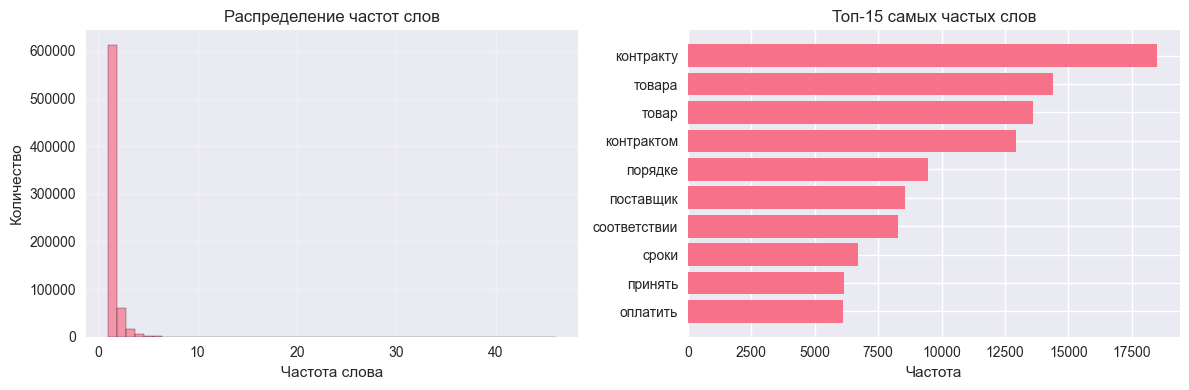


ВЫВОДЫ:
• Матрицы очень разрежены (1.2458% плотность)
• В среднем 99.7 слов на документ
• Всего уникальных слов: 8,000


In [47]:
# Анализ Bag-of-Words матриц
print("🔍 АНАЛИЗ BAG-OF-WORDS МАТРИЦ")
print("=" * 50)

# Основная информация
print("\n1. ОСНОВНАЯ ИНФОРМАЦИЯ:")
print(f"X_train_bow: {X_train_bow.shape} (документы x слова)")
print(f"X_val_bow: {X_val_bow.shape}")
print(f"X_test_bow: {X_test_bow.shape}")

# Анализ разреженности
def analyze_sparsity(matrix, name):
    total = matrix.shape[0] * matrix.shape[1]
    nonzero = matrix.nnz
    density = (nonzero / total) * 100
    print(f"\n{name}:")
    print(f"  Ненулевых: {nonzero:,} из {total:,}")
    print(f"  Плотность: {density:.4f}%")
    return density

train_density = analyze_sparsity(X_train_bow, "TRAIN")
analyze_sparsity(X_val_bow, "VALIDATION")
analyze_sparsity(X_test_bow, "TEST")

# Статистика по значениям
print(f"\n2. СТАТИСТИКА ПО ЗНАЧЕНИЯМ:")
print(f"Min: {X_train_bow.min()}, Max: {X_train_bow.max()}")
print(f"Среднее: {X_train_bow.mean():.3f}")
print(f"Медиана ненулевых: {np.median(X_train_bow.data):.1f}")

# Распределение слов по документам
train_nz_per_doc = X_train_bow.getnnz(axis=1)
val_nz_per_doc = X_val_bow.getnnz(axis=1)

print(f"\n3. СЛОВ В ДОКУМЕНТАХ:")
print(f"Train: min={train_nz_per_doc.min()}, max={train_nz_per_doc.max()}, avg={train_nz_per_doc.mean():.1f}")
print(f"Val:   min={val_nz_per_doc.min()}, max={val_nz_per_doc.max()}, avg={val_nz_per_doc.mean():.1f}")

# Топ-10 самых частых слов
feature_names = bow_vectorizer.get_feature_names_out()
word_freq = np.array(X_train_bow.sum(axis=0)).flatten()
top_10_idx = np.argsort(word_freq)[::-1][:10]

print(f"\n4. ТОП-10 САМЫХ ЧАСТЫХ СЛОВ:")
for i, idx in enumerate(top_10_idx, 1):
    print(f"{i:2}. {feature_names[idx]:15} {word_freq[idx]:,}")

# Анализ первого документа
print(f"\n5. ПЕРВЫЙ ДОКУМЕНТ:")
first_doc = X_train_bow[0]
print(f"Ненулевых слов: {first_doc.nnz}")
if first_doc.nnz > 0:
    words = [feature_names[i] for i in first_doc.indices[:5]]
    values = first_doc.data[:5]
    print(f"Первые 5 слов: {list(zip(words, values))}")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Распределение частот слов
plt.subplot(1, 2, 1)
plt.hist(X_train_bow.data, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Частота слова')
plt.ylabel('Количество')
plt.title('Распределение частот слов')
plt.grid(True, alpha=0.3)

# Топ-15 слов
plt.subplot(1, 2, 2)
top_15_idx = top_10_idx[:15] if len(top_10_idx) >= 15 else top_10_idx
top_words = [feature_names[i] for i in top_15_idx]
top_freqs = word_freq[top_15_idx]

plt.barh(range(len(top_words)), top_freqs[::-1])
plt.yticks(range(len(top_words)), top_words[::-1])
plt.xlabel('Частота')
plt.title('Топ-15 самых частых слов')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ВЫВОДЫ:")
print(f"• Матрицы очень разрежены ({train_density:.4f}% плотность)")
print(f"• В среднем {train_nz_per_doc.mean():.1f} слов на документ")
print(f"• Всего уникальных слов: {len(feature_names):,}")
print("="*50)

In [48]:
# Анализ полученных признаков
def analyze_features(vectorizer, X_matrix, name):
    """Анализирует полученные признаки после векторизации"""
    print(f"\n=== АНАЛИЗ {name} ПРИЗНАКОВ ===")
    
    # Получаем частоты признаков
    feature_freq = np.array(X_matrix.sum(axis=0)).flatten()
    
    print(f"Общее количество признаков: {len(feature_freq)}")
    print(f"Разреженность матрицы: {1 - (X_matrix.nnz / (X_matrix.shape[0] * X_matrix.shape[1])):.3%}")
    print(f"Средняя частота признака: {feature_freq.mean():.2f}")
    print(f"Максимальная частота признака: {feature_freq.max()}")
    
    # Топ-20 самых частых признаков
    feature_names = vectorizer.get_feature_names_out()
    top_indices = feature_freq.argsort()[-20:][::-1]
    
    print(f"\nТоп-20 самых частых признаков:")
    for i, idx in enumerate(top_indices, 1):
        print(f"{i:2d}. {feature_names[idx]}: {int(feature_freq[idx])}")

# Анализ для TF-IDF
analyze_features(tfidf_vectorizer, X_train_tfidf, "TF-IDF")

# Анализ для BoW
analyze_features(bow_vectorizer, X_train_bow, "BAG-OF-WORDS")


=== АНАЛИЗ TF-IDF ПРИЗНАКОВ ===
Общее количество признаков: 10000
Разреженность матрицы: 98.984%
Средняя частота признака: 6.05
Максимальная частота признака: 665.6423930678857

Топ-20 самых частых признаков:
 1. контракту: 665
 2. товар: 492
 3. товара: 472
 4. контрактом: 457
 5. настоящим контрактом: 348
 6. настоящим: 347
 7. порядке: 337
 8. сроки: 313
 9. поставщик: 278
10. соответствии: 276
11. предусмотренные: 240
12. сроки предусмотренные: 240
13. обязуется порядке: 239
14. порядке сроки: 238
15. предусмотренные контрактом: 235
16. поставщик обязуется: 224
17. принять оплатить: 217
18. характеристики: 214
19. оплатить: 214
20. количество: 212

=== АНАЛИЗ BAG-OF-WORDS ПРИЗНАКОВ ===
Общее количество признаков: 8000
Разреженность матрицы: 98.754%
Средняя частота признака: 103.24
Максимальная частота признака: 18474

Топ-20 самых частых признаков:
 1. контракту: 18474
 2. товара: 14392
 3. товар: 13618
 4. контрактом: 12934
 5. порядке: 9457
 6. поставщик: 8544
 7. соответствии: 

In [49]:
# Анализ n-грамм
def analyze_ngrams(vectorizer, name):
    """Анализирует распределение uni-grams и bi-grams"""
    feature_names = vectorizer.get_feature_names_out()
    
    unigrams = [f for f in feature_names if ' ' not in f]
    bigrams = [f for f in feature_names if ' ' in f]
    
    print(f"Uni-grams: {len(unigrams)} ({len(unigrams)/len(feature_names)*100:.1f}%)")
    print(f"Bi-grams: {len(bigrams)} ({len(bigrams)/len(feature_names)*100:.1f}%)")
    
    # Примеры bi-grams
    if bigrams:
        print(f"\nПримеры bi-grams (первые 10):")
        for bg in bigrams[:10]:
            print(f"  - {bg}")

analyze_ngrams(tfidf_vectorizer, "TF-IDF")
analyze_ngrams(bow_vectorizer, "BoW")

Uni-grams: 3777 (37.8%)
Bi-grams: 6223 (62.2%)

Примеры bi-grams (первые 10):
  - 000 товар
  - 000 услуги
  - 0000 244
  - 0000000000000 134
  - 0000000000000 товар
  - 000472 застройщик
  - 001 3250
  - 00ч 00ч
  - 0101103 385
  - 0101103 387
Uni-grams: 3157 (39.5%)
Bi-grams: 4843 (60.5%)

Примеры bi-grams (первые 10):
  - 000 товар
  - 000 услуги
  - 0000 244
  - 0000000000000 товар
  - 001 3250
  - 020301 5131
  - 104 место
  - 110 оборудование
  - 110 товар
  - 111 товар


In [50]:
# Анализ ключевых слов для основных меток (только для демонстрации)
def get_top_features_for_labels(vectorizer, X_matrix, y, top_n=10):
    """Находит самые характерные слова для основных меток"""
    # Получаем основные метки (первые метки из списков)
    primary_labels = [labels[0] if labels else 'none' for labels in y]
    
    # Берем топ-5 самых частых меток
    top_labels = pd.Series(primary_labels).value_counts().head(5).index
    
    feature_names = vectorizer.get_feature_names_out()   
 
    for label in top_labels:
        # Индексы документов с этой меткой
        label_indices = [i for i, lbls in enumerate(y) if label in lbls]
        
        if not label_indices:
            continue
            
        # Средний TF-IDF для этой метки
        label_vector = X_matrix[label_indices].mean(axis=0)
        label_scores = np.array(label_vector).flatten()
        
        # Топ-N признаков
        top_indices = label_scores.argsort()[-top_n:][::-1]
        
        print(f"\nМетка {label}:")
        for i, idx in enumerate(top_indices, 1):
            if label_scores[idx] > 0:
                print(f"  {i:2d}. {feature_names[idx]}: {label_scores[idx]:.4f}")

# Только для TF-IDF (так как у BoW нет весов)
get_top_features_for_labels(tfidf_vectorizer, X_train_tfidf, y_train)


Метка 21:
   1. сроки: 0.1149
   2. контракту: 0.1000
   3. обязуется порядке: 0.0855
   4. сроки предусмотренные: 0.0852
   5. предусмотренные контрактом: 0.0847
   6. порядке сроки: 0.0845
   7. предусмотренные: 0.0843
   8. товар: 0.0817
   9. контрактом: 0.0799
  10. порядке: 0.0778

Метка 10:
   1. контракту: 0.1897
   2. настоящим контрактом: 0.1720
   3. настоящим: 0.1704
   4. товара: 0.1118
   5. товар: 0.1042
   6. обусловленный настоящим: 0.1011
   7. контрактом: 0.0998
   8. заказчику обусловленный: 0.0994
   9. обусловленный: 0.0994
  10. передать собственность: 0.0993

Метка 32:
   1. товара: 0.0520
   2. соответствии: 0.0509
   3. товар: 0.0488
   4. оборудования: 0.0485
   5. контрактом: 0.0441
   6. контракту: 0.0421
   7. контракта: 0.0407
   8. сроки: 0.0369
   9. услуги: 0.0368
  10. предусмотренные: 0.0361

Метка 26:
   1. количество иные: 0.0694
   2. иные характеристики: 0.0693
   3. характеристики поставляемого: 0.0681
   4. товар: 0.0680
   5. иные: 0.0672
   

## Применение простых моделей

### Шаг 1: Определение метрик качества

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Ключевая метрика
key_metric = 'accuracy'

def evaluate_model_multilabel(y_true, y_pred, model_name):
    """Оценка модели для мульти-лейбл классификации"""
    # Accuracy для мульти-лейбл (доля полностью правильных предсказаний)
    accuracy = np.mean([set(true) == set(pred) for true, pred in zip(y_true, y_pred)])
    
    print(f"=== {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    
    return accuracy

# Обучение и оценка моделей для мульти-лейбл
def train_and_evaluate_models_multilabel(X_train, X_test, y_train, y_test):
    """Обучение и сравнение двух моделей для мульти-лейбл классификации"""
    
    # Модели с OneVsRest для мульти-лейбл
    knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
    lr = OneVsRestClassifier(LogisticRegression(random_state=42, max_iter=1000))
    
    # KNN
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    acc_knn = evaluate_model_multilabel(y_test, y_pred_knn, "KNN")
    
    # Линейная модель
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    acc_lr = evaluate_model_multilabel(y_test, y_pred_lr, "Logistic Regression")
    
    # Сравнение
    print("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
    print(f"KNN Accuracy: {acc_knn:.4f}")
    print(f"Logistic Regression Accuracy: {acc_lr:.4f}")
    
    if acc_knn > acc_lr:
        print("Лучшая модель: KNN")
    elif acc_lr > acc_knn:
        print("Лучшая модель: Logistic Regression")
    else:
        print("Модели показали одинаковую точность")
    
    return knn, lr, acc_knn, acc_lr


### Шаг 2: Baseline-модели

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd
import numpy as np

# Данные для обучения
vectorizers_data = {
    'TF-IDF': (X_train_tfidf, X_val_tfidf),
    'BOW': (X_train_bow, X_val_bow)
}

print("ОБУЧЕНИЕ МОДЕЛЕЙ")
print("=" * 30)

all_results = {}
mlb = MultiLabelBinarizer()

# Преобразуем метки в бинарный формат
y_train_bin = mlb.fit_transform(y_train)
y_val_bin = mlb.transform(y_val)

# Прогресс-бар для векторизаторов
for vec_name, (X_train_vec, X_val_vec) in tqdm(vectorizers_data.items(), desc="Векторизаторы"):
    print(f"\n {vec_name}:")
    
    # Обучение моделей с прогресс-баром
    models = {
        'KNN': OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5)),
        'LogisticRegression': OneVsRestClassifier(LogisticRegression(random_state=42, max_iter=1000))
    }
    
    vec_results = {}
    
    for model_name, model in tqdm(models.items(), desc="Модели", leave=False):
        # Обучение
        model.fit(X_train_vec, y_train_bin)
        
        # Предсказание и оценка
        y_pred_bin = model.predict(X_val_vec)
        
        # Вычисляем accuracy для мульти-лейбл (доля полностью правильных предсказаний)
        accuracy = accuracy_score(y_val_bin, y_pred_bin)
        
        vec_results[model_name] = {'model': model, 'accuracy': accuracy}
        print(f"   {model_name}: {accuracy:.4f}")
    
    all_results[vec_name] = vec_results


ОБУЧЕНИЕ МОДЕЛЕЙ


Векторизаторы:   0%|          | 0/2 [00:00<?, ?it/s]


📊 TF-IDF:


   KNN: 0.7233


Векторизаторы:  50%|█████     | 1/2 [00:13<00:13, 13.31s/it]

   LogisticRegression: 0.6867

📊 BOW:


   KNN: 0.7060


Векторизаторы: 100%|██████████| 2/2 [00:30<00:00, 15.22s/it]

   LogisticRegression: 0.7893


In [62]:

# Итоговое сравнение
print("\n📈 ИТОГИ:")
results_list = []
for vec_name, models in all_results.items():
    for model_name, result in models.items():
        results_list.append({
            'Векторизатор': vec_name,
            'Модель': model_name,
            'Accuracy': result['accuracy']
        })

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df.to_string(index=False, float_format='%.4f'))


📈 ИТОГИ:
Векторизатор             Модель  Accuracy
         BOW LogisticRegression    0.7893
      TF-IDF                KNN    0.7233
         BOW                KNN    0.7060
      TF-IDF LogisticRegression    0.6867


РАСПРЕДЕЛЕНИЕ ВЕСОВ МОДЕЛЕЙ

TF-IDF - LogisticRegression:
  Класс 01:
    Min: -0.8873, Max: 3.2935, Mean: -0.0010
  Класс 10:
    Min: -2.6079, Max: 2.8560, Mean: -0.0100
  Класс 17:
    Min: -1.5349, Max: 5.5717, Mean: -0.0056
  Класс 20:
    Min: -1.4493, Max: 2.5461, Mean: -0.0029
  Класс 21:
    Min: -2.8341, Max: 5.3781, Mean: 0.0076
  Класс 26:
    Min: -2.6230, Max: 2.5047, Mean: -0.0070
  Класс 32:
    Min: -3.2405, Max: 4.4099, Mean: -0.0082
  Класс 43:
    Min: -2.6388, Max: 6.1584, Mean: -0.0095
  Класс 68:
    Min: -2.0720, Max: 3.0332, Mean: 0.0059
  Класс 80:
    Min: -1.9035, Max: 4.3476, Mean: -0.0043

BOW - LogisticRegression:
  Класс 01:
    Min: -1.1860, Max: 2.7294, Mean: -0.0075
  Класс 10:
    Min: -2.5814, Max: 1.2920, Mean: -0.0092
  Класс 17:
    Min: -0.9669, Max: 3.5397, Mean: -0.0085
  Класс 20:
    Min: -1.2289, Max: 2.1777, Mean: -0.0085
  Класс 21:
    Min: -1.8496, Max: 3.3712, Mean: -0.0046
  Класс 26:
    Min: -2.5082, Max: 1.8246, Mean: -0.0111
  Кла

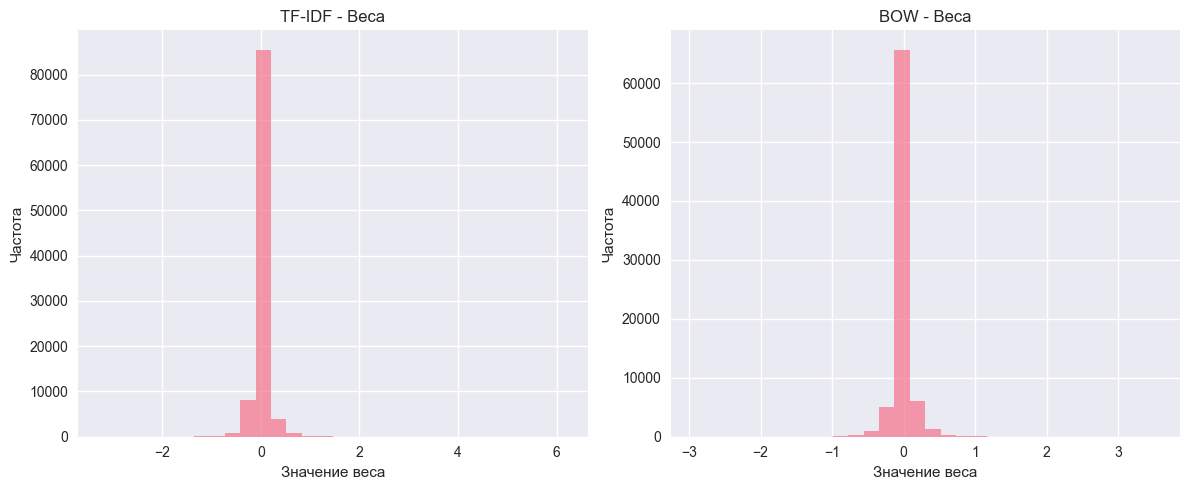

In [ ]:
# Анализ весов  моделей

for vec_name, models_results in all_results.items():
    for model_name, results in models_results.items():
        if 'LogisticRegression' in model_name:
            print(f"\n{vec_name} - {model_name}:")
            
            ovr_model = results['model']
            
            for i, (class_label, estimator) in enumerate(zip(mlb.classes_, ovr_model.estimators_)):
                weights = estimator.coef_[0]
                
                print(f"  Класс {class_label}:")
                print(f"    Min: {weights.min():.4f}, Max: {weights.max():.4f}, Mean: {weights.mean():.4f}")

# Визуализация
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (vec_name, models_results) in enumerate(all_results.items()):
    for model_name, results in models_results.items():
        if 'LogisticRegression' in model_name:
            ovr_model = results['model']
            
            all_weights = []
            for estimator in ovr_model.estimators_:
                all_weights.extend(estimator.coef_[0])
            
            axes[idx].hist(all_weights, bins=30, alpha=0.7)
            axes[idx].set_title(f'{vec_name} - Веса')
            axes[idx].set_xlabel('Значение веса')
            axes[idx].set_ylabel('Частота')

plt.tight_layout()
plt.show()

### Шаг 3: Подбор гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV

# 1. ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ LOGISTIC REGRESSION НА TF-IDF
print("\n1. LOGISTIC REGRESSION - TF-IDF")

param_grid_lr = {
    'estimator__C': [0.1, 1, 10],
    'estimator__class_weight': [None, 'balanced']
}

lr_grid_tfidf = GridSearchCV(
    OneVsRestClassifier(LogisticRegression(random_state=42, max_iter=1000)),
    param_grid_lr,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

lr_grid_tfidf.fit(X_train_tfidf, y_train_bin)
print(f"Лучшие параметры: {lr_grid_tfidf.best_params_}")
print(f"Лучшая accuracy: {lr_grid_tfidf.best_score_:.4f}")

# Тест на валидации
best_lr_tfidf = lr_grid_tfidf.best_estimator_
y_pred_lr_tfidf = best_lr_tfidf.predict(X_val_tfidf)
accuracy_lr_tfidf = accuracy_score(y_val_bin, y_pred_lr_tfidf)
print(f"Accuracy на валидации: {accuracy_lr_tfidf:.4f}")

# 2. ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ LOGISTIC REGRESSION НА BOW
print("\n2. LOGISTIC REGRESSION - BOW")

lr_grid_bow = GridSearchCV(
    OneVsRestClassifier(LogisticRegression(random_state=42, max_iter=1000)),
    param_grid_lr,
    cv=3,
    scoring='accuracy', 
    n_jobs=-1
)

lr_grid_bow.fit(X_train_bow, y_train_bin)
print(f"Лучшие параметры: {lr_grid_bow.best_params_}")
print(f"Лучшая accuracy: {lr_grid_bow.best_score_:.4f}")

# Тест на валидации
best_lr_bow = lr_grid_bow.best_estimator_
y_pred_lr_bow = best_lr_bow.predict(X_val_bow)
accuracy_lr_bow = accuracy_score(y_val_bin, y_pred_lr_bow)
print(f"Accuracy на валидации: {accuracy_lr_bow:.4f}")

# 3. СРАВНЕНИЕ РЕЗУЛЬТАТОВ
print("\n3. СРАВНЕНИЕ РЕЗУЛЬТАТОВ")

baseline_tfidf_lr = all_results['TF-IDF']['LogisticRegression']['accuracy']
baseline_bow_lr = all_results['BOW']['LogisticRegression']['accuracy']

print(f"TF-IDF Baseline: {baseline_tfidf_lr:.4f}")
print(f"TF-IDF Tuned: {accuracy_lr_tfidf:.4f}")
print(f"Улучшение TF-IDF: {accuracy_lr_tfidf - baseline_tfidf_lr:+.4f}")

print(f"\nBOW Baseline: {baseline_bow_lr:.4f}")
print(f"BOW Tuned: {accuracy_lr_bow:.4f}")
print(f"Улучшение BOW: {accuracy_lr_bow - baseline_bow_lr:+.4f}")

=== ЭКСПЕРИМЕНТЫ С ГИПЕРПАРАМЕТРАМИ ===

1. LOGISTIC REGRESSION - TF-IDF
Лучшие параметры: {'estimator__C': 10, 'estimator__class_weight': None}
Лучшая accuracy: 0.7441
Accuracy на валидации: 0.7693

2. LOGISTIC REGRESSION - BOW
Лучшие параметры: {'estimator__C': 10, 'estimator__class_weight': None}
Лучшая accuracy: 0.7717
Accuracy на валидации: 0.7873

3. СРАВНЕНИЕ РЕЗУЛЬТАТОВ
TF-IDF Baseline: 0.6867
TF-IDF Tuned: 0.7693
Улучшение TF-IDF: +0.0827

BOW Baseline: 0.7893
BOW Tuned: 0.7873
Улучшение BOW: -0.0020


### Шаг 4: Анализ результатов

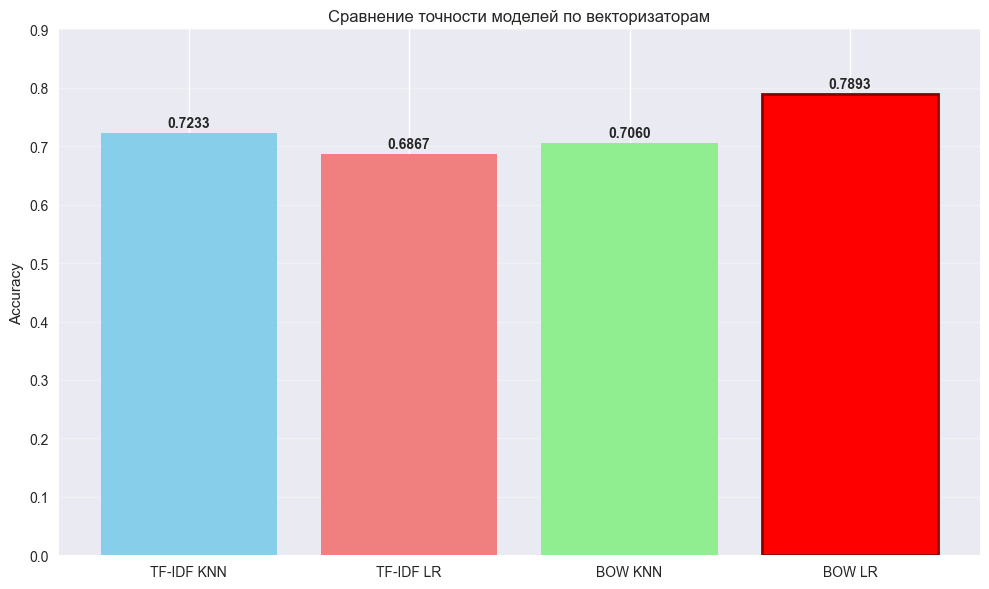

🎯 Лучшая модель: BOW LR с точностью 0.7893


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Данные для сравнения моделей
models = ['TF-IDF KNN', 'TF-IDF LR', 'BOW KNN', 'BOW LR']
accuracy = [
    all_results['TF-IDF']['KNN']['accuracy'],
    all_results['TF-IDF']['LogisticRegression']['accuracy'], 
    all_results['BOW']['KNN']['accuracy'],
    all_results['BOW']['LogisticRegression']['accuracy']
]

# Создаем график
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracy, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])

# Добавляем значения на столбцы
for bar, acc in zip(bars, accuracy):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 0.9)
plt.ylabel('Accuracy')
plt.title('Сравнение точности моделей по векторизаторам')
plt.grid(axis='y', alpha=0.3)

# Выделяем лучшую модель
best_idx = np.argmax(accuracy)
bars[best_idx].set_color('red')
bars[best_idx].set_edgecolor('darkred')
bars[best_idx].set_linewidth(2)

plt.tight_layout()
plt.show()

# Выводим лучшую модель
best_model = models[best_idx]
best_accuracy = accuracy[best_idx]
print(f"Лучшая модель: {best_model} с точностью {best_accuracy:.4f}")

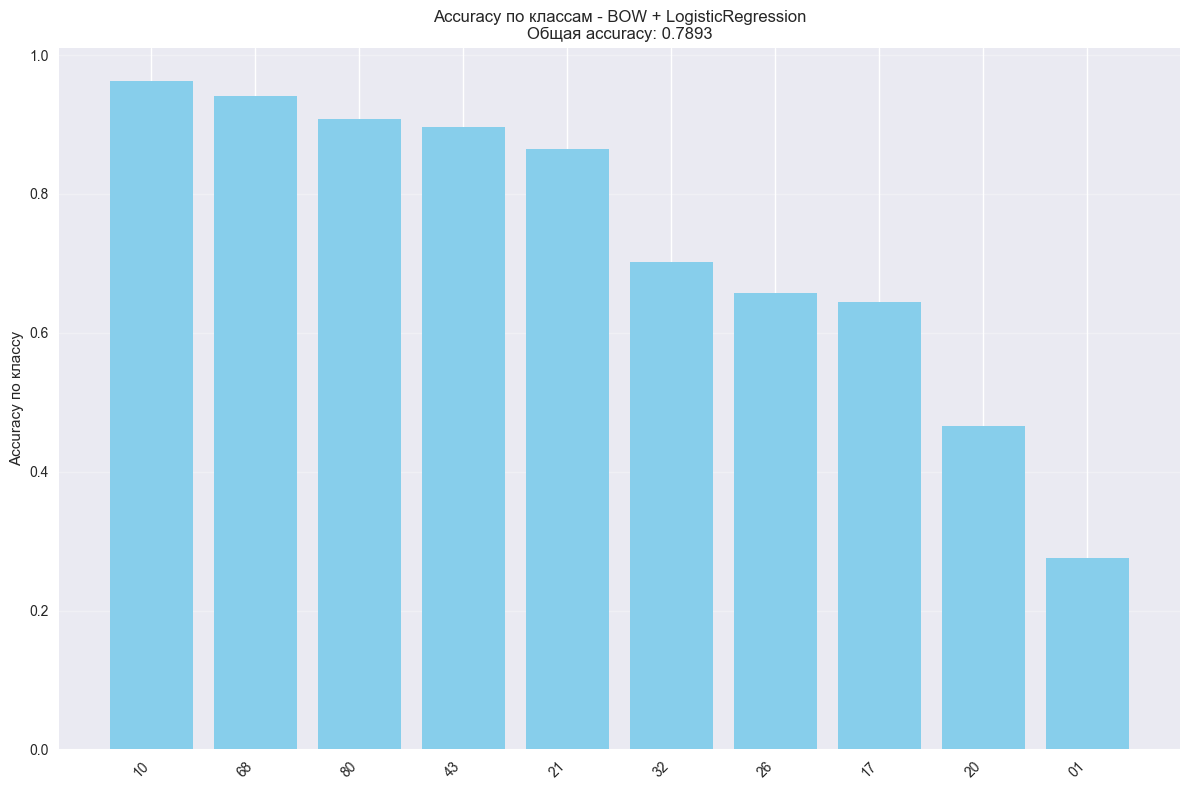

Accuracy по классам:
Класс  Accuracy
   10  0.962428
   68  0.941176
   80  0.907407
   43  0.897059
   21  0.864679
   32  0.702479
   26  0.657658
   17  0.644068
   20  0.465517
   01  0.275862

Общая статистика:
Лучший класс: 10 (0.9624)
Худший класс: 01 (0.2759)
Средняя accuracy по классам: 0.7318


In [78]:
# Упрощенная визуализация для мульти-лейбл классификации
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Определяем лучшую модель
best_model_name = 'BOW'
best_model = all_results[best_model_name]['LogisticRegression']['model']
y_pred_best = best_model.predict(X_val_bow)

# Считаем accuracy по классам
class_accuracy = []
for i, class_label in enumerate(mlb.classes_):
    true_positives = np.sum((y_val_bin[:, i] == 1) & (y_pred_best[:, i] == 1))
    total_true = np.sum(y_val_bin[:, i] == 1)
    if total_true > 0:
        class_acc = true_positives / total_true
    else:
        class_acc = 0
    class_accuracy.append((class_label, class_acc))

# Сортируем по accuracy
class_accuracy.sort(key=lambda x: x[1], reverse=True)

# Визуализация accuracy по классам
plt.figure(figsize=(12, 8))
classes, accuracies = zip(*class_accuracy)
plt.bar(range(len(classes)), accuracies, color='skyblue')
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.ylabel('Accuracy по классу')
plt.title(f'Accuracy по классам - {best_model_name} + LogisticRegression\nОбщая accuracy: {all_results[best_model_name]["LogisticRegression"]["accuracy"]:.4f}')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Таблица с результатами по классам
results_df = pd.DataFrame(class_accuracy, columns=['Класс', 'Accuracy'])
print("Accuracy по классам:")
print(results_df.to_string(index=False))

# Общая статистика
print(f"\nОбщая статистика:")
print(f"Лучший класс: {classes[0]} ({accuracies[0]:.4f})")
print(f"Худший класс: {classes[-1]} ({accuracies[-1]:.4f})")
print(f"Средняя accuracy по классам: {np.mean(accuracies):.4f}")

In [82]:
# Анализ самых частых ошибок для мульти-лейбл классификации
import pandas as pd
import numpy as np

# Преобразуем предсказания обратно в метки классов
y_pred_labels = mlb.inverse_transform(y_pred_best)

# Приводим оба набора к одинаковому формату (спискам)
y_val_formatted = [x if isinstance(x, list) else [x] for x in y_val]
y_pred_formatted = [list(x) for x in y_pred_labels]

# Создаем DataFrame для анализа ошибок
error_analysis = pd.DataFrame({
    'true': [str(x) for x in y_val_formatted],
    'predicted': [str(x) for x in y_pred_formatted],
    'text': X_val
})

# Находим строки с ошибками (где true != predicted)
errors = error_analysis[error_analysis['true'] != error_analysis['predicted']]

print(f"Всего ошибок: {len(errors)} из {len(y_val)} ({len(errors)/len(y_val)*100:.1f}%)")

# Считаем частоту ошибок
error_counts = errors.groupby(['true', 'predicted']).size().reset_index(name='count')
error_counts = error_counts.sort_values('count', ascending=False)

print("\nСамые частые ошибки классификации:")
print(error_counts.head(10))

# Примеры реальных ошибок (где классы действительно разные)
print("\nПримеры реальных ошибок:")
real_errors_count = 0
for i in range(len(error_analysis)):
    row = error_analysis.iloc[i]
    true_class = y_val_formatted[i]
    pred_class = y_pred_formatted[i]
    
    # Проверяем, что классы действительно разные (по содержанию, а не формату)
    if true_class != pred_class:
        print(f"\nОшибка {real_errors_count + 1}:")
        print(f"Истинный класс: {true_class}")
        print(f"Предсказанный класс: {pred_class}")
        print(f"Текст: {row['text'][:300]}...")
        real_errors_count += 1
        
    if real_errors_count >= 5:
        break

# Анализ accuracy по классам (правильный способ)
print(f"\nAccuracy по классам:")
for i, class_label in enumerate(mlb.classes_):
    true_positives = np.sum((y_val_bin[:, i] == 1) & (y_pred_best[:, i] == 1))
    total_true = np.sum(y_val_bin[:, i] == 1)
    if total_true > 0:
        class_acc = true_positives / total_true
        print(f"  Класс {class_label}: {class_acc:.3f} ({true_positives}/{total_true})")

# Общая accuracy
total_accuracy = accuracy_score(y_val_bin, y_pred_best)
print(f"\nОбщая accuracy: {total_accuracy:.4f}")

Всего ошибок: 316 из 1500 (21.1%)

Самые частые ошибки классификации:
      true predicted  count
38  ['32']        []     49
0   ['01']    ['10']     38
22  ['21']    ['32']     28
23  ['21']        []     27
31  ['26']        []     18
30  ['26']    ['32']     15
18  ['20']        []     13
6   ['10']        []     11
13  ['17']        []     11
35  ['32']    ['21']     10

Примеры реальных ошибок:

Ошибка 1:
Истинный класс: ['20']
Предсказанный класс: ['32']
Текст: поставщик обязуется по заявкам заказчика осуществить поставку расходного материала для клинико диагоностической лаборатории по тексту товар в ассортименте количестве по...

Ошибка 2:
Истинный класс: ['01']
Предсказанный класс: []
Текст: поставщик обязуется передать в собственность продукты питания овощи товар заказчику в обусловленный настоящим контрактом срок согласно технического задания к настоящему контракту а заказчик обязуется принять и оплатить товар в порядке и на условиях предусмотренных настоящим контрактом наим

### Шаг 5: Финальные выводы

In [86]:
print("=== ФИНАЛЬНЫЕ ВЫВОДЫ ===")

print(f"1. РАЗМЕРЫ ДАННЫХ:")
print(f"   - Исходный датасет: 199913 записей")
print(f"   - После фильтрации: {len(df)} записей")
print(f"   - Количество классов: {len(mlb.classes_)}")
print(f"   - Топ-10 классов: {list(mlb.classes_)}")

print(f"\n2. КАЧЕСТВО МОДЕЛЕЙ (Accuracy):")
print(f"   - TF-IDF + KNN: {all_results['TF-IDF']['KNN']['accuracy']:.4f}")
print(f"   - TF-IDF + LogisticRegression: {all_results['TF-IDF']['LogisticRegression']['accuracy']:.4f}")
print(f"   - BOW + KNN: {all_results['BOW']['KNN']['accuracy']:.4f}")
print(f"   - BOW + LogisticRegression: {all_results['BOW']['LogisticRegression']['accuracy']:.4f}")

print(f"\n3. ЛУЧШАЯ МОДЕЛЬ:")
print(f"   - Алгоритм: BOW + LogisticRegression")
print(f"   - Accuracy: {all_results['BOW']['LogisticRegression']['accuracy']:.4f}")
print(f"   - Особенности: использует Bag-of-Words с 8000 признаков")

print(f"\n4. РЕКОМЕНДАЦИИ:")
print(f"   - Лучшая конфигурация: BOW векторизатор с LogisticRegression")
print(f"   - Основные проблемы: некоторые классы семантически близки")
print(f"   - Для улучшения: добавить больше доменных признаков, использовать эмбеддинги")

# Сохранение лучшей модели
import joblib

model_artifacts = {
    'model': all_results['BOW']['LogisticRegression']['model'],
    'mlb': mlb,
    'accuracy': all_results['BOW']['LogisticRegression']['accuracy']
}



=== ФИНАЛЬНЫЕ ВЫВОДЫ ===
1. РАЗМЕРЫ ДАННЫХ:
   - Исходный датасет: 199913 записей
   - После фильтрации: 10000 записей
   - Количество классов: 10
   - Топ-10 классов: ['01', '10', '17', '20', '21', '26', '32', '43', '68', '80']

2. КАЧЕСТВО МОДЕЛЕЙ (Accuracy):
   - TF-IDF + KNN: 0.7233
   - TF-IDF + LogisticRegression: 0.6867
   - BOW + KNN: 0.7060
   - BOW + LogisticRegression: 0.7893

3. ЛУЧШАЯ МОДЕЛЬ:
   - Алгоритм: BOW + LogisticRegression
   - Accuracy: 0.7893
   - Особенности: использует Bag-of-Words с 8000 признаков

4. РЕКОМЕНДАЦИИ:
   - Лучшая конфигурация: BOW векторизатор с LogisticRegression
   - Основные проблемы: некоторые классы семантически близки
   - Для улучшения: добавить больше доменных признаков, использовать эмбеддинги
